# A modified CenterNet architecture for oriented bounding box detection

See the CenterNet official repo : https://github.com/xingyizhou/CenterNet

The main goal of this repo is to demonstrate how we can adapt the CenterNet ideas to multiple cars from a Bird Eye View as oriented bounding boxes. We train our network to predict a heatmap of the <b>box center</b> that is refined with an <b>offset map</b>. Then <b>bounding boxes dimensions</b> are regressed to get length and width of the vehicle. Orientation angle is also inferred with 2 heatmaps, <b>one for cosine and for sine</b>. In terms of architecture, another difference with CenterNet is that we are not using any upsampling layers, since detection of small objects doesnt require a global information of the original image.

# Summary
- import and display your dataset
- define utility functions to draw heatmaps and how we can recover oriented bounding boxes from main heatmap, offset heatmaps, width and height heatmaps, and sine/cosine heatmaps
- make a Pytorch dataset for training and validation
- define the model with a Resnet-18 backbone
- define our loss
- train the network
- display a few predictions on the validation dataset

# Imports

In [1]:
import cv2
import numpy as np
import os
import pandas as pd
import re
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from collections import OrderedDict
from sklearn.model_selection import train_test_split
import timm
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torchsummary import summary
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
assert torch.cuda.is_available()
import math
# Not always necessary depending on your hardware/GPU
#os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"

In [2]:
# Here we dont assume that our images are 512x512 we prefer to use HD images (more common)
input_width = 512 
input_height = 512

# Model scale is 16, meaning that in the model prediction, we have heatmaps of dimensions 80 x 45
MODEL_SCALE = 4 #32 #16 #4

# Batch size for training --> if your hardware supports it, try to increase this value
batch_size = 8#24

In [3]:
def draw_gaussian(heatmap, center, radius, k=1):
    diameter = 2 * radius + 1
    gaussian = gaussian2D((diameter, diameter), sigma=diameter / 6)

    x, y = int(center[0]), int(center[1])

    height, width = heatmap.shape[0:2]

    left, right = min(x, radius), min(width - x, radius + 1)
    top, bottom = min(y, radius), min(height - y, radius + 1)

    masked_heatmap = heatmap[y - top:y + bottom, x - left:x + right]
    masked_gaussian = gaussian[radius - top:radius + bottom, radius - left:radius + right]
    if min(masked_gaussian.shape) > 0 and min(masked_heatmap.shape) > 0:  # TODO debug
        np.maximum(masked_heatmap, masked_gaussian * k, out=masked_heatmap)
    return heatmap

def gaussian2D(shape, sigma=1):
    m, n = [(ss - 1.) / 2. for ss in shape]
    y, x = np.ogrid[-m:m + 1, -n:n + 1]

    h = np.exp(-(x * x + y * y) / (2 * sigma * sigma))
    h[h < np.finfo(h.dtype).eps * h.max()] = 0
    return h

def gaussian_radius(det_size, min_overlap=0.9):
    height, width = det_size

    a1 = 1
    b1 = (height + width)
    c1 = width * height * (1 - min_overlap) / (1 + min_overlap)
    sq1 = np.sqrt(b1 ** 2 - 4 * a1 * c1)
    r1 = (b1 + sq1) / 2

    a2 = 4
    b2 = 2 * (height + width)
    c2 = (1 - min_overlap) * width * height
    sq2 = np.sqrt(b2 ** 2 - 4 * a2 * c2)
    r2 = (b2 + sq2) / 2

    a3 = 4 * min_overlap
    b3 = -2 * min_overlap * (height + width)
    c3 = (min_overlap - 1) * width * height
    sq3 = np.sqrt(b3 ** 2 - 4 * a3 * c3)
    r3 = (b3 + sq3) / 2
    return min(r1, r2, r3)

def draw_umich_gaussian(heatmap, center, radius, k=1):
  diameter = 2 * radius + 1
  gaussian = gaussian2D((diameter, diameter), sigma=diameter / 6)
  
  x, y = int(center[0]), int(center[1])

  height, width = heatmap.shape[0:2]
    
  left, right = min(x, radius), min(width - x, radius + 1)
  top, bottom = min(y, radius), min(height - y, radius + 1)

  masked_heatmap  = heatmap[y - top:y + bottom, x - left:x + right]
  masked_gaussian = gaussian[radius - top:radius + bottom, radius - left:radius + right]
  if min(masked_gaussian.shape) > 0 and min(masked_heatmap.shape) > 0: # TODO debug
    np.maximum(masked_heatmap, masked_gaussian * k, out=masked_heatmap)
  return heatmap


In [4]:
def scatter_gaussian_kernel(heatmap, bbox_icx, bbox_icy, bbox_w, bbox_h, alpha=0.54):
    heatmap_h, heatmap_w = heatmap.shape
    dtype = heatmap.dtype
    device = heatmap.device
    
    std_w = alpha * bbox_w/6.
    std_h = alpha * bbox_h/6.
    
    var_w = std_w ** 2
    var_h = std_h ** 2
    
    grid_y, grid_x = torch.meshgrid([torch.arange(heatmap_h, dtype=dtype, device=device),
                                     torch.arange(heatmap_w, dtype=dtype, device=device)])
    
    gaussian_kernel = torch.exp(-((grid_x - bbox_icx)**2/(2. * var_w))-((grid_y - bbox_icy)**2/(2. * var_h)))
    gaussian_kernel[bbox_icy, bbox_icx] = 1.
    heatmap = torch.maximum(heatmap, gaussian_kernel)
    return heatmap

Image 468_random.jpg


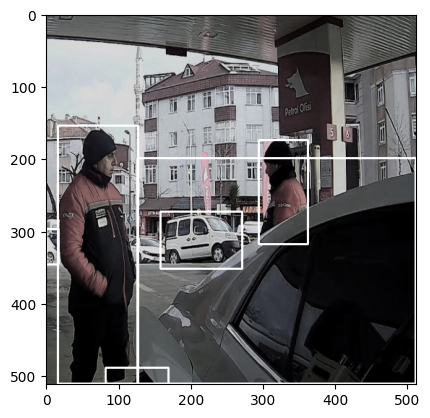

In [5]:
dataset_folder = '/home/rivian/Desktop/Datasets/derpet_v4_label_tf/'
labels_file = dataset_folder +  "train_annotations.csv"
    
# Pick up a random image
IMAGE = random.choice(os.listdir(dataset_folder+"train_images"))

print(f"Image {IMAGE}")

img = cv2.imread(os.path.join(dataset_folder+"train_images", IMAGE))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img,(input_width,input_height))
# Load labels
train_df = pd.read_csv(labels_file)
classes = train_df["label_name"].unique()

train_df['x'] = train_df['bbox_x'].astype(float) * (input_width / 1280)
train_df['y'] = train_df['bbox_y'].astype(float) * (input_height / 720)
train_df['w'] = train_df['bbox_width'].astype(float) * (input_width / 1280)  #- train_df['xmin'].astype(float)
train_df['h'] = train_df['bbox_height'].astype(float) * (input_height / 720) #- train_df['ymin'].astype(float)
target = train_df[train_df['image_name']==IMAGE]
centers = np.array([target["x"], target["y"]]).T
bboxs = target[["x", "y", "w", "h"]].to_numpy().astype(int)
train_df.head()
for box in bboxs:
    cv2.rectangle(img,(box[0],box[1]),(box[0]+box[2],box[1]+box[3]),(255,255,255),2)
plt.imshow(img)

Image 64_vlcsnap-2023-04-06-11h27m16s262.png
['HORTUM' 'PLAKA' 'NOZZLE' 'KISI' 'BINEK' 'TICARI' 'TAKILDI' 'TERS'
 'MOTOSIKLET' 'BIDON']


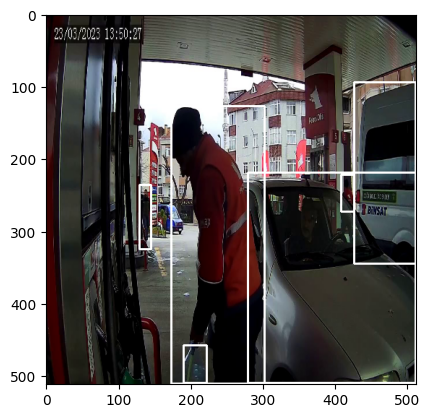

In [6]:
dataset_folder = '/home/rivian/Desktop/Datasets/derpet_v4_label_tf/'
val_labels_file = dataset_folder +  "valid_annotations.csv"
    
# Pick up a random image
val_IMAGE = random.choice(os.listdir(dataset_folder+"val_images"))

print(f"Image {val_IMAGE}")

img = cv2.imread(os.path.join(dataset_folder+"val_images", val_IMAGE))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img,(input_width,input_height))
# Load labels
val_df = pd.read_csv(val_labels_file)
classes_val = val_df["label_name"].unique()
print(classes_val)
val_df['x'] = val_df['bbox_x'].astype(float) * (input_width / 1280)
val_df['y'] = val_df['bbox_y'].astype(float) * (input_height / 720)
val_df['w'] = val_df['bbox_width'].astype(float) * (input_width / 1280)  #- train_df['xmin'].astype(float)
val_df['h'] = val_df['bbox_height'].astype(float) * (input_height / 720) #- train_df['ymin'].astype(float)
val_target = val_df[val_df['image_name']==val_IMAGE]
val_centers = np.array([val_target["x"], val_target["y"]]).T
bboxs = val_target[["x", "y", "w", "h"]].to_numpy().astype(int)
val_df.head()
for box in bboxs:
    cv2.rectangle(img,(box[0],box[1]),(box[0]+box[2],box[1]+box[3]),(255,255,255),2)
plt.imshow(img)

# Load dataset

dataset_folder = '/home/ai/Desktop/Datasets/box_4corner_img/'
labels_file = dataset_folder +  "labels.csv"

# Pick up a random image
IMAGE = random.choice(os.listdir(dataset_folder+"train"))

print(f"Image {IMAGE}")

img = cv2.imread(os.path.join(dataset_folder+"train", IMAGE))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


# Load labels
train_df = pd.read_csv(labels_file)
train_df['x'] = train_df['x'].astype(float)
train_df['y'] = train_df['y'].astype(float)
train_df['w'] = train_df['w'].astype(float)
train_df['h'] = train_df['l'].astype(float)
train_df['angle'] = train_df['angle'].astype(float)

print(f"Image shape = {img.shape}")

target = train_df[train_df['name']==IMAGE[:-4]]
print(target)

# convert targets to its center.
centers = np.array([target["x"], target["y"]]).T

rotations = []
for angle in target["angle"]:
    cos_angle = np.cos(angle)
    sin_angle = np.sin(angle)
    rotations.append(np.array([[cos_angle, sin_angle], [-sin_angle, cos_angle]]))

bboxs = target[["x", "y", "w", "l"]].to_numpy()

for center, rot, box in zip(centers, rotations, bboxs):
    bottom_right = np.dot(rot, np.array([box[2]/2, box[3]/2]).reshape(2, 1)).reshape(2)
    top_right = np.dot(rot, np.array([box[2]/2, -box[3]/2]).reshape(2, 1)).reshape(2)
    top_left = np.dot(rot, np.array([-box[2]/2, -box[3]/2]).reshape(2, 1)).reshape(2)
    bottom_left = np.dot(rot, np.array([-box[2]/2, box[3]/2]).reshape(2, 1)).reshape(2)
    
    br = (int(center[0]+bottom_right[0]), int(center[1]+bottom_right[1]))
    tr = (int(center[0]+top_right[0]), int(center[1]+top_right[1]))
    tl = (int(center[0]+top_left[0]), int(center[1]+top_left[1]))
    bl = (int(center[0]+bottom_left[0]), int(center[1]+bottom_left[1]))

    thickness = 3
    cv2.line(img, br, tr, (0, 220, 0), thickness)
    cv2.line(img, br, bl, (220, 220, 0), thickness)
    cv2.line(img, tl, bl, (220, 220, 0), thickness)
    cv2.line(img, tl, tr, (220, 220, 0), thickness)

#plt.figure(figsize=(14,14))
plt.imshow(img)

# Utility functions

Let's plot center points into the image.

In [7]:
# Make heatmaps using the utility functions from the centernet repo
def draw_msra_gaussian(heatmap, center, sigma=2):
    tmp_size = sigma * 6
    mu_x = int(center[0])
    mu_y = int(center[1])
    w, h = heatmap.shape[0], heatmap.shape[1]
    ul = [int(mu_x - tmp_size), int(mu_y - tmp_size)]
    br = [int(mu_x + tmp_size + 1), int(mu_y + tmp_size + 1)]
    if ul[0] >= h or ul[1] >= w or br[0] < 0 or br[1] < 0:
        return heatmap
    size = br[0] - ul[0]
    x = np.arange(0, size, 1, np.float32)
    y = x[:, np.newaxis]
    x0 = y0 = size // 2
    g = np.exp(- ((x - x0) ** 2 + (y - y0) ** 2) / (2 * sigma ** 2))
    g_x = max(0, -ul[0]), min(br[0], h) - ul[0]
    g_y = max(0, -ul[1]), min(br[1], w) - ul[1]
    img_x = max(0, ul[0]), min(br[0], h)
    img_y = max(0, ul[1]), min(br[1], w)
    heatmap[img_y[0]:img_y[1], img_x[0]:img_x[1]] = np.maximum(
      heatmap[img_y[0]:img_y[1], img_x[0]:img_x[1]],
      g[g_y[0]:g_y[1], g_x[0]:g_x[1]])
    
    assert heatmap[mu_y, mu_x] == 1 # Center value must be 1
    return heatmap

# Offsets along x and y are between 0 and 1 and correct quantization errors from center heatmap
def draw_offset(offset, x, y):
    offset[0, int(y), int(x)] = x - int(x)
    offset[1, int(y), int(x)] = y - int(y)
    return offset

In [8]:
for i, c in train_df.iterrows():
    print(i,c)
    break

0 label_name                                      BINEK
bbox_x                                            479
bbox_y                                            383
bbox_width                                         59
bbox_height                                        36
image_name      0_vlcsnap-2023-04-06-11h46m20s433.png
image_width                                      1280
image_height                                      720
x                                               191.6
y                                          272.355556
w                                                23.6
h                                                25.6
Name: 0, dtype: object


In [9]:
classes

array(['BINEK', 'KISI', 'PLAKA', 'TAKILDI', 'HORTUM', 'MOTOSIKLET',
       'TICARI', 'NOZZLE', 'TERS', 'BIDON'], dtype=object)

In [10]:
# Heatmap function
# MODEL_SCALE = 16 ==> 1280 to 80, 720 ==> 45
def make_hm_offset_regr_angle(target):
    hm = np.zeros([len(classes),input_height//MODEL_SCALE, input_width//MODEL_SCALE])
    hm_all = np.zeros([input_height//MODEL_SCALE, input_width//MODEL_SCALE])
    offset = np.zeros([2, input_height//MODEL_SCALE, input_width//MODEL_SCALE])
    regr = np.zeros([2, input_height//MODEL_SCALE, input_width//MODEL_SCALE])
    #cos_sin_hm = np.zeros([2, input_height//MODEL_SCALE, input_width//MODEL_SCALE])
     
    if len(target) == 0:
        return hm, offset, regr , hm_all
    
    # choice of sigma is important here, if you are working with very tiny objects, you should decrease the sigma value
    for i, c in target.iterrows():
        #bbox[3] - bbox[1], bbox[2] - bbox[0]
        w =   c["w"] 
        h =  c["h"]
        
        c["x"] = (c["x"] + ( c["x"] + c["w"])) / 2
        c["y"] = (c["y"] + ( c["y"] + c["h"])) / 2
        
        cls = list(classes).index(c["label_name"])

        radius = gaussian_radius((math.ceil(h), math.ceil(w)))
        radius = max(0, int(radius))
        diameter = 2 * radius + 1
        sigma = diameter / 6

        # hm[cls] = draw_gaussian(hm[cls], [int(c["x"]/MODEL_SCALE), int(c["y"]/MODEL_SCALE)], radius)
        # hm_all = draw_gaussian(hm_all, [int(c["x"]/MODEL_SCALE), int(c["y"]/MODEL_SCALE)], radius)zeros((128,128)),55,50,42,65).cpu().numpy()
        draw_umich_gaussian(hm[cls], [int(c["x"]/MODEL_SCALE), int(c["y"]/MODEL_SCALE)],radius)
        # hm[cls] = draw_msra_gaussian(hm[cls], [int(c["x"]/MODEL_SCALE), int(c["y"]/MODEL_SCALE)], 
        #                         sigma=sigma)
        hm_all = draw_msra_gaussian(hm_all, [int(c["x"]/MODEL_SCALE), int(c["y"]/MODEL_SCALE)], 
                                sigma=sigma)
        
        assert 0 <= c["x"] < input_width
        assert 0 <= c["y"] < input_height
        offset = draw_offset(offset, c["x"]/MODEL_SCALE, c["y"]/MODEL_SCALE)
        
        for i in range(-1, 2):
            for j in range(-1, 2):
                try:
                    regr[0, int(c["y"]/MODEL_SCALE)+i, int(c["x"]/MODEL_SCALE)+j] = c["w"]/MODEL_SCALE
                    regr[1, int(c["y"]/MODEL_SCALE)+i, int(c["x"]/MODEL_SCALE)+j] = c["h"]/MODEL_SCALE
                    #cos_sin_hm[0, int(c["y"]/MODEL_SCALE)+i, int(c["x"]/MODEL_SCALE)+j] = np.cos(c["angle"])
                    #cos_sin_hm[1, int(c["y"]/MODEL_SCALE)+i, int(c["x"]/MODEL_SCALE)+j] = np.sin(c["angle"])
                except:
                    pass
        #angles= target["angle"]
        
                
    #regr[0] = regr[0].T; regr[1] = regr[1].T;
    #angle = angle.T
    return hm, offset, regr, hm_all #, cos_sin_hm


In [11]:
def select(hm, threshold):
    """
    Keep only local maxima (kind of NMS).
    We make sure to have no adjacent detection in the heatmap.
    """

    pred = hm > threshold
    pred_centers = np.argwhere(pred)

    for i, ci in enumerate(pred_centers):
        for j in range(i + 1, len(pred_centers)):
            cj = pred_centers[j]
            if np.linalg.norm(ci - cj) <= 2:
                score_i = hm[ci[0], ci[1]]
                score_j = hm[cj[0], cj[1]]
                if score_i > score_j:
                    hm[cj[0], cj[1]] = 0
                else:
                    hm[ci[0], ci[1]] = 0

    return hm

In [12]:
def pred2box(hm, offset, regr, thresh=0.5):
    # make binding box from heatmaps
    # thresh: threshold for logits.
        
    # get center
    pred = hm > thresh
    pred_center = np.where(hm>thresh)
    
    # get regressions
    pred_r = regr[:,pred].T
    print(pred_r)
    print(regr[:,pred])
    #pred_angles = cos_sin_hm[:, pred].T
    
    #print("pred_angle", pred_angle)

    # wrap as boxes
    # [xmin, ymin, width, height]
    # size as original image.
    boxes = []
    scores = hm[pred]
    
    pred_center = np.asarray(pred_center).T
    #print(pred_r.shape)
    #print(pred_angles)
    #print(pred_angles.shape)
    
    for (center, b) in zip(pred_center, pred_r):
        #print(b)
        offset_xy = offset[:, center[0], center[1]]
        #angle = np.arctan2(pred_angle[1], pred_angle[0])
        arr = np.array([(center[1]+offset_xy[0])*MODEL_SCALE, (center[0]+offset_xy[1])*MODEL_SCALE, 
                        b[0]*MODEL_SCALE, b[1]*MODEL_SCALE])
        # Clip values between 0 and input_size
        #arr = np.clip(arr, 0, input_size)
        #print("Pred angle", i, pred_angle[i])
        # filter 
        #if arr[0]<0 or arr[1]<0 or arr[0]>input_size or arr[1]>input_size:
            #pass
        boxes.append(arr)
    return np.asarray(boxes), scores

In [13]:
# functions for plotting results
def showbox(img, hm, offset, regr, thresh=0.9):
    boxes, _ = pred2box(hm, offset, regr, thresh=thresh)
    
    sample = img

    for box in boxes:
        center = [int(box[0]), int(box[1])] 
        #cos_angle = np.cos(box[4])
        #sin_angle = np.sin(box[4])
        #rot = np.array([[cos_angle, sin_angle], [-sin_angle, cos_angle]])
        reg_w = int(box[2]) 
        reg_h = int(box[3])
        print(center)
        
        xmin = center[0] - (reg_w / 2)
        ymin = center[1] - (reg_h / 2)
        xmax = center[0] + (reg_w / 2)
        ymax = center[1] + (reg_h / 2)
        
        xmin = int(xmin)
        ymin = int(ymin)
        xmax = int(xmax)
        ymax = int(ymax)
        
        cv2.rectangle(sample,(xmin,ymin),(xmax,ymax),(255,255,255),2)
        # bottom_right = np.dot(rot, np.array([box[2]/2, box[3]/2]).reshape(2, 1)).reshape(2)
        # top_right = np.dot(rot, np.array([box[2]/2, -box[3]/2]).reshape(2, 1)).reshape(2)
        # top_left = np.dot(rot, np.array([-box[2]/2, -box[3]/2]).reshape(2, 1)).reshape(2)
        # bottom_left = np.dot(rot, np.array([-box[2]/2, box[3]/2]).reshape(2, 1)).reshape(2)
        
        # thickness = 3
        # cv2.line(sample, (int(center[0]+bottom_right[0]), int(center[1]+bottom_right[1])),
        #               (int(center[0]+top_right[0]), int(center[1]+top_right[1])),
        #               (0, 220, 0), thickness)
        # cv2.line(sample, (int(center[0]+bottom_right[0]), int(center[1]+bottom_right[1])),
        #               (int(center[0]+bottom_left[0]), int(center[1]+bottom_left[1])),
        #               (220, 220, 0), thickness)
        # cv2.line(sample, (int(center[0]+top_left[0]), int(center[1]+top_left[1])),
        #               (int(center[0]+bottom_left[0]), int(center[1]+bottom_left[1])),
        #               (220, 220, 0), thickness)
        # cv2.line(sample, (int(center[0]+top_left[0]), int(center[1]+top_left[1])),
        #               (int(center[0]+top_right[0]), int(center[1]+top_right[1])),
        #               (220, 220, 0), thickness)
    return sample


# Make Pytorch dataset with dataloader

In [14]:
# Split train-test by unique image ids, corresponding to image paths
train_id = os.listdir(dataset_folder+"train_images")
val_id = os.listdir(dataset_folder+"val_images")

In [15]:
# Resnet-18 expect normalized channels in input
class Normalize(object):
    def __init__(self):
        self.mean=[0.485, 0.456, 0.406]
        self.std=[0.229, 0.224, 0.225]
        self.norm = transforms.Normalize(self.mean, self.std)
    def __call__(self, image):
        image = image.astype(np.float32)/255
        axis = (0,1)
        image -= self.mean
        image /= self.std
        return image
    

class CarDataset(torch.utils.data.Dataset):
    def __init__(self, img_id, labels,val, transform=None):
        self.img_id = img_id
        self.labels = labels
        self.val = val
        if transform:
            self.transform = transform
        self.normalize = Normalize()
        
    def __len__(self):
        return len(self.img_id)

    def __getitem__(self, idx):
        if self.val == True: f_name = "val_images"
        else: f_name = "train_images" 
        img = cv2.imread(os.path.join(dataset_folder+f_name, self.img_id[idx]))
        img = cv2.resize(img,(input_width,input_height))
        img = self.normalize(img)
        img = img.transpose([2,0,1])
        target = self.labels[self.labels['image_name']==self.img_id[idx]]
        hm, offset, regr,hm_all = make_hm_offset_regr_angle(target)
        #assert(hm.shape == (128, 128))
        #assert(regr.shape == (2, 128, 128))
        #assert(angle.shape == (128, 128))
        return img, hm, offset, regr,hm_all


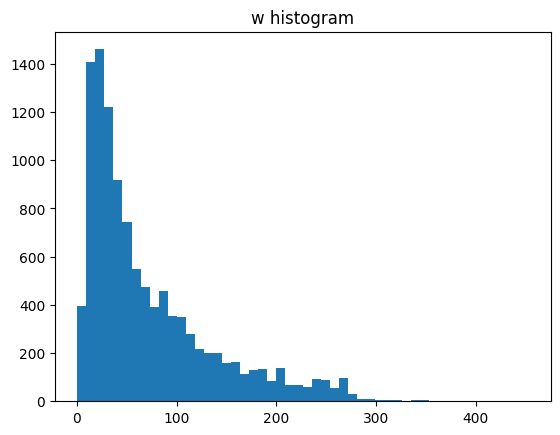

In [16]:
traindataset = CarDataset(train_id, train_df,val=False)
valdataset = CarDataset(val_id, val_df,val=True)

# Your angle histogram should be as flat as possible to reduce overfitting!
target = train_df["w"]
plt.hist(target, bins=50)
plt.title("w histogram")
plt.show()


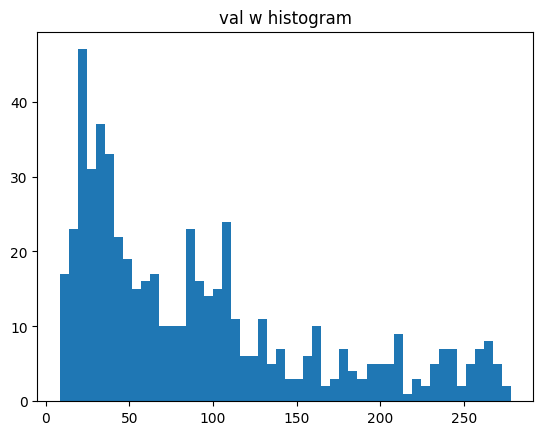

In [17]:
valtarget = val_df["w"]
plt.hist(valtarget, bins=50)
plt.title("val w histogram")
plt.show()

In [18]:
classes

array(['BINEK', 'KISI', 'PLAKA', 'TAKILDI', 'HORTUM', 'MOTOSIKLET',
       'TICARI', 'NOZZLE', 'TERS', 'BIDON'], dtype=object)

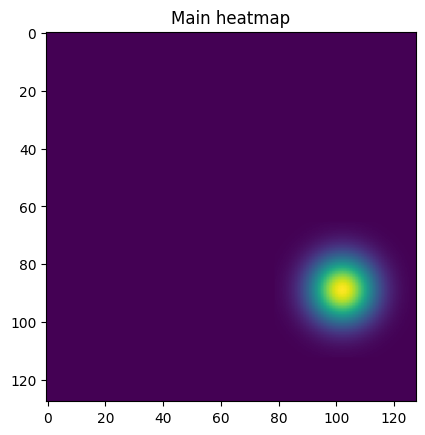

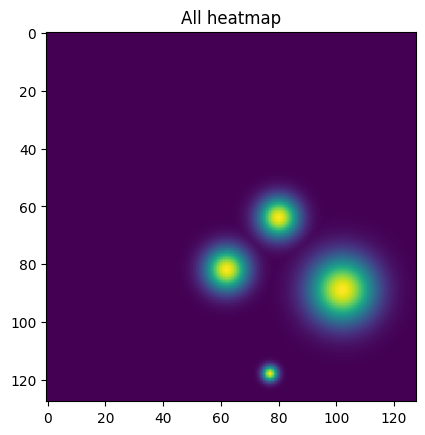

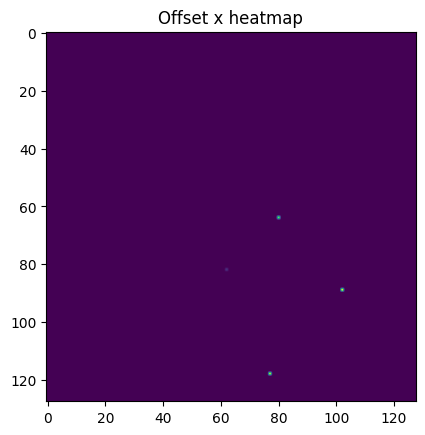

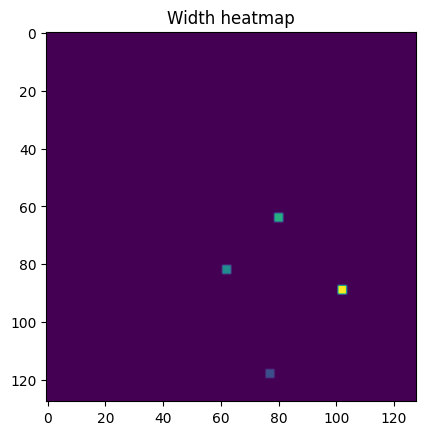

[[50.3        76.62222222]
 [50.3        76.62222222]
 [50.3        76.62222222]
 [50.3        76.62222222]
 [50.3        76.62222222]]
[[50.3        50.3        50.3        50.3        50.3       ]
 [76.62222222 76.62222222 76.62222222 76.62222222 76.62222222]]
[408, 352]
[404, 356]
[411, 358]
[412, 356]
[408, 360]


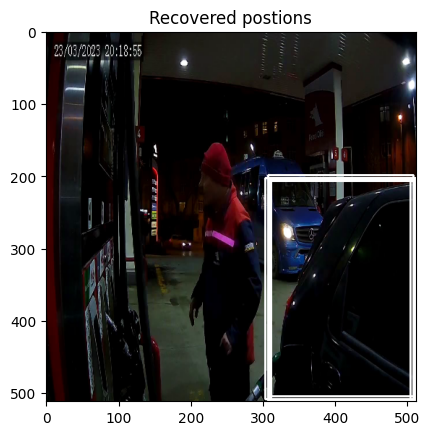

In [19]:
# Check traindataset

k = random.randint(0, len(train_id))
# Test dataset
img, hm, offset, regr,hm_all = traindataset[k]

plt.imshow(hm[0])
plt.title("Main heatmap")
plt.show()

plt.imshow(hm_all)
plt.title("All heatmap")
plt.show()

plt.imshow(offset[0])
plt.title("Offset x heatmap")
plt.show()

plt.imshow(regr[0])
plt.title("Width heatmap")
plt.show()

#print(cos_sin_hm.shape)

# plt.imshow(cos_sin_hm[0])
# plt.title("Cos heatmap")
# plt.show()

# plt.imshow(cos_sin_hm[1])
# plt.title("Sin heatmap")
# plt.show()

# Recover ball detection from heatmaps
img = cv2.imread(os.path.join(dataset_folder+"train_images", train_id[k]))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img,(input_width,input_height))
img = showbox(img, hm[0], offset, regr, 0.99)

plt.imshow(img)
plt.title("Recovered postions")
plt.show()

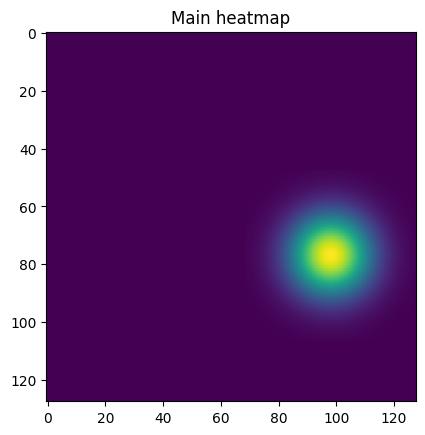

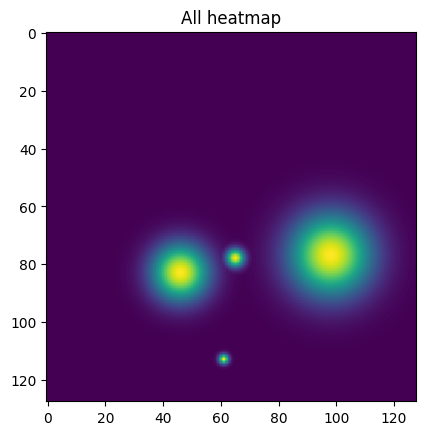

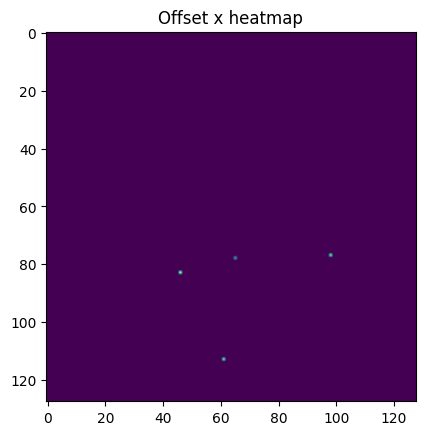

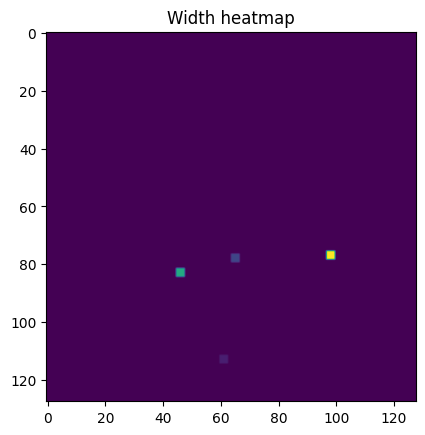

[[ 59.         100.62222222]
 [ 59.         100.62222222]
 [ 59.         100.62222222]
 [ 59.         100.62222222]
 [ 59.         100.62222222]]
[[ 59.          59.          59.          59.          59.        ]
 [100.62222222 100.62222222 100.62222222 100.62222222 100.62222222]]
[392, 304]
[388, 308]
[394, 310]
[396, 308]
[392, 312]


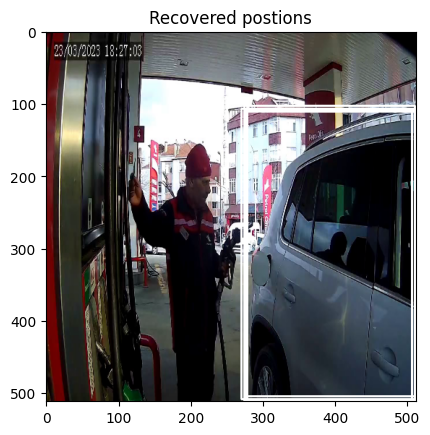

In [20]:
# Check traindataset
k = random.randint(0, len(val_id))
# Test dataset
img, hm, offset, regr,hm_all = valdataset[k]

plt.imshow(hm[0])
plt.title("Main heatmap")
plt.show()

plt.imshow(hm_all)
plt.title("All heatmap")
plt.show()

plt.imshow(offset[0])
plt.title("Offset x heatmap")
plt.show()

plt.imshow(regr[0])
plt.title("Width heatmap")
plt.show()

#print(cos_sin_hm.shape)

# plt.imshow(cos_sin_hm[0])
# plt.title("Cos heatmap")
# plt.show()

# plt.imshow(cos_sin_hm[1])
# plt.title("Sin heatmap")
# plt.show()

# Recover ball detection from heatmaps
img = cv2.imread(os.path.join(dataset_folder+"val_images", val_id[k]))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img,(input_width,input_height))
img = showbox(img, hm[0], offset, regr, 0.99)

plt.imshow(img)
plt.title("Recovered postions")
plt.show()

In [21]:
train_loader = torch.utils.data.DataLoader(traindataset,batch_size=batch_size,shuffle=True)
val_loader = torch.utils.data.DataLoader(valdataset,batch_size=batch_size,shuffle=False)

In [22]:
timm.list_models()

['bat_resnext26ts',
 'beit_base_patch16_224',
 'beit_base_patch16_384',
 'beit_large_patch16_224',
 'beit_large_patch16_384',
 'beit_large_patch16_512',
 'beitv2_base_patch16_224',
 'beitv2_large_patch16_224',
 'botnet26t_256',
 'botnet50ts_256',
 'caformer_b36',
 'caformer_m36',
 'caformer_s18',
 'caformer_s36',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_medium',
 'coat_lite_medium_384',
 'coat_lite_mini',
 'coat_lite_small',
 'coat_lite_tiny',
 'coat_mini',
 'coat_small',
 'coat_tiny',
 'coatnet_0_224',
 'coatnet_0_rw_224',
 'coatnet_1_224',
 'coatnet_1_rw_224',
 'coatnet_2_224',
 'coatnet_2_rw_224',
 'coatnet_3_224',
 'coatnet_3_rw_224',
 'coatnet_4_224',
 'coatnet_5_224',
 'coatnet_bn_0_rw_224',
 'coatnet_nano_cc_224',
 'coatnet_nano_rw_224',
 'coatnet_pico_rw_224',
 'coatnet_rmlp_0_rw_224',
 'coatnet_rmlp_1_rw2_224',
 'coatnet_rmlp_1_r

In [23]:
#finiş

In [24]:
name = 'focalnet_tiny_srf'
basemodel = timm.create_model(name, features_only=True, pretrained=True)
o = basemodel(torch.rand(1,3,input_width,input_height))
fsize = []
for x in o:
    #print(x.size(2))
    if x.size(3) == input_width // 8:
        #print("Size is 160",x.shape)
        fsize.append(x.size(1))
        
    if x.size(3) == input_width // 16:
        #print("Size is 80",x.shape)
        fsize.append(x.size(1))
    
    if x.size(3) == input_width // 32:
        #print("Size is 40",x.shape)
        fsize.append(x.size(1))
fsize

[192, 384, 768]

In [25]:
for i in o:
    print(i.shape)

torch.Size([1, 96, 128, 128])
torch.Size([1, 192, 64, 64])
torch.Size([1, 384, 32, 32])
torch.Size([1, 768, 16, 16])


In [26]:
class DeformableConv2d(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size=3,
                 stride=1,
                 padding=1,
                 bias=False):

        super(DeformableConv2d, self).__init__()

        self.padding = padding
        
        self.offset_conv = nn.Conv2d(in_channels, 
                                     2 * kernel_size * kernel_size,
                                     kernel_size=kernel_size, 
                                     stride=stride,
                                     padding=self.padding, 
                                     bias=True)

        nn.init.constant_(self.offset_conv.weight, 0.)
        nn.init.constant_(self.offset_conv.bias, 0.)
        
        self.modulator_conv = nn.Conv2d(in_channels, 
                                     1 * kernel_size * kernel_size,
                                     kernel_size=kernel_size, 
                                     stride=stride,
                                     padding=self.padding, 
                                     bias=True)

        nn.init.constant_(self.modulator_conv.weight, 0.)
        nn.init.constant_(self.modulator_conv.bias, 0.)
        
        self.regular_conv = nn.Conv2d(in_channels=in_channels,
                                      out_channels=out_channels,
                                      kernel_size=kernel_size,
                                      stride=stride,
                                      padding=self.padding,
                                      bias=bias)
    
    def forward(self, x):
        h, w = x.shape[2:]
        #max_offset = max(h, w)/4.

        offset = self.offset_conv(x)#.clamp(-max_offset, max_offset)
        modulator = 2. * torch.sigmoid(self.modulator_conv(x))
        
        x = torchvision.ops.deform_conv2d(input=x, 
                                          offset=offset, 
                                          weight=self.regular_conv.weight, 
                                          bias=self.regular_conv.bias, 
                                          padding=self.padding,
                                          mask=modulator
                                          )
        return x

In [27]:
def fill_up_weights(up):
    w = up.weight.data
    f = math.ceil(w.size(2) / 2)
    c = (2 * f - 1 - f % 2) / (2. * f)
    for i in range(w.size(2)):
        for j in range(w.size(3)):
            w[:, 0, i, j] = \
                (1 - math.fabs(i / f - c)) * (1 - math.fabs(j / f - c))



class Upsamling(nn.Module):
    def __init__(self, in_channels, out_channels, ksize, stride=2):
        super(Upsamling, self).__init__()
        # deconv basic config
        if ksize == 4:
            padding = 1
            output_padding = 0
        elif ksize == 3:
            padding = 1
            output_padding = 1
        elif ksize == 2:
            padding = 0
            output_padding = 0
        
        self.conv = DeformableConv2d(in_channels, out_channels)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        self.up = nn.ConvTranspose2d(out_channels, out_channels, ksize, stride=stride, padding=padding, output_padding=output_padding, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        fill_up_weights(self.up)

    def forward(self, x):
        x = torch.relu(self.bn1(self.conv(x)))
        x = torch.relu(self.bn2(self.up(x)))
        return x
    

## Define Centernet model

In [28]:
class centernet(nn.Module):
    def __init__(self):
        super(centernet, self).__init__()
        
        # Resnet-18 as backbone.
        #basemodel = timm.create_model('dla34', features_only=True, pretrained=True)
        #torchvision.models.resnet18(pretrained=True)
        
        # DO NOT FREEZE ResNet weights
        #for param in basemodel.parameters():
        #    param.requires_grad = False
        
        # Select only first layers up when you reach 80x45 dimensions with 256 channels
        self.base_model = basemodel #nn.Sequential(*list(basemodel.children())[:-3])

        self.low_level = nn.Conv2d(64, 256, kernel_size=3, padding=1)
        self.upsampler = nn.Upsample(scale_factor=2, mode='nearest') 
        self.mid_level = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.high_level = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.fpn_ = torchvision.ops.FeaturePyramidNetwork(fsize, 256)
        
        num_ch = 256
        head_conv = 64
        self.outc = nn.Sequential(
                nn.Conv2d(num_ch, head_conv, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(head_conv, len(classes), kernel_size=1, stride=1))
        
        self.outo = nn.Sequential(
                nn.Conv2d(num_ch, head_conv, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(head_conv, 2, kernel_size=1, stride=1))
        
        self.outr = nn.Sequential(
                nn.Conv2d(num_ch, head_conv, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(head_conv, 2, kernel_size=1, stride=1))
        
        self.outa = nn.Sequential(
                nn.Conv2d(num_ch, head_conv, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(head_conv, 2, kernel_size=1, stride=1))

        self.upsample1 = Upsamling(256, 256, ksize=4, stride=2) # 32 -> 16
        self.upsample2 = Upsamling(256, 128, ksize=4, stride=2) # 16 -> 8
        self.upsample3 = Upsamling(128, 256, ksize=4, stride=2) #  8 -> 4
        
    def forward(self, x):
        # [b, 3, 720, 1280]
        
        o = self.base_model(x)

        ll_ml_hl = []
        for x in o:
            #print(x.size(2))
            if x.size(3) == input_width // 8:
                #print("Size is 160",x.shape)
                ll_ml_hl.append(x)
                
            if x.size(3) == input_width // 16:
                #print("Size is 80",x.shape)
                ll_ml_hl.append(x)
        
            if x.size(3) == input_width // 32:
                #print("Size is 40",x.shape)
                ll_ml_hl.append(x)

        low_level = ll_ml_hl[0]
        mid_level = ll_ml_hl[1]
        high_level = ll_ml_hl[2]

        # high = self.upsampler(self.high_level(high_level)) #256,80,80
        # mid = self.mid_level(mid_level) + high #256,80,80
        # low = self.upsampler(mid) + self.low_level(low_level) #256,160,160 

        x_feats = OrderedDict()
        x_feats['feat0'] = low_level
        x_feats['feat2'] = mid_level
        x_feats['feat3'] = high_level

        # x = low
        fpn_res = self.fpn_(x_feats)
        #x = high_level
        x = fpn_res['feat3']
        
        x = self.upsample1(x)
        x = self.upsample2(x)
        x = self.upsample3(x)
        # [b, 128, 90, 160] 
        
        assert not torch.isnan(x).any()
        
        outc = self.outc(x) 
        # [b, 1, 90, 160]
        assert not torch.isnan(outc).any()
        
        outo = self.outo(x)
        # [b, 2, 90, 160]
        assert not torch.isnan(outo).any()
        
        outr = self.outr(x)
        #outa = self.outa(x)
        
        return outc, outo, outr #, outa

# Define Loss (Focal loss + L1-loss)

In [29]:
def focal_loss(pred_mask, gt,gamma=0.2):
    """
    Focal loss was introduced to address the class imbalance problem
    For example here, most of the pixels in the heatmap are negative.
    
    We split the focal loss between positive and negative losses.
    
    https://arxiv.org/pdf/1708.02002.pdf
    
    Code taken from the CenterNet repo.
    """
    gt = gt.unsqueeze(1).float()

    pos_inds = gt.ge(1.0).float()
    neg_inds = gt.lt(1.0).float()
    
    neg_weights = torch.pow(1 - gt, 4)
    
    # add 1e-12 to avoid nan values
    pos_loss = - torch.pow(1 - pred_mask, gamma) * torch.log(pred_mask + 1e-12) * pos_inds # [2, 1, 128, 128]
    neg_loss = - torch.pow(pred_mask, gamma) * torch.log(1 - pred_mask + 1e-12) * neg_inds * neg_weights # [2, 1, 128, 128]
    
    loss = 0
    
    num_pos  = pos_inds.float().sum() # scalar number of positives
    pos_loss = pos_loss.sum()
    neg_loss = neg_loss.sum()
    
    if num_pos == 0:
        loss = neg_loss
    else:
        pos_loss /= num_pos
        neg_loss /= num_pos
        loss = pos_loss + neg_loss
        
    assert not torch.isnan(pos_loss)
    assert not torch.isnan(neg_loss)
        
    return loss, pos_loss, neg_loss


def _regr_loss(off_pred, off_gt, wh_pred, wh_gt, hm_all):
    ''' L1 regression loss
    We compute l1 loss over mask of positive pixels for offset, width/height and sine/cosine angle
    '''
    #hm_gt = torch.sum(hm_gt,axis=1)

    mask = hm_all.unsqueeze(1).float().ge(1.0).float()
    
    num = mask.float().sum() 
    mask = mask.expand_as(off_gt).float()
    
    assert off_pred.size() == mask.size()
    off_pred = off_pred * mask
    off_gt = off_gt * mask
    wh_pred = wh_pred * mask
    wh_gt = wh_gt * mask
    # angle_pred = angle_pred * mask
    # angle_gt = angle_gt * mask
    

    off_loss = nn.functional.l1_loss(off_pred, off_gt, reduction='sum') / (num + 1e-4)
    
    # Scale with 0.1 width and height loss (change it you need)
    wh_loss = 0.1 * nn.functional.l1_loss(wh_pred, wh_gt, reduction='sum') / (num + 1e-4)
    
    #angle_loss = nn.functional.l1_loss(angle_pred, angle_gt, reduction='sum') / (num + 1e-4)
    
    return off_loss, wh_loss #, angle_loss

def global_loss(hm_pred, hm_gt, off_pred, off_gt, wh_pred, wh_gt,hm_all):
    """
    Global loss is the sum of the focal loss and of the offset loss
        
    Focal loss is the sum of pos_loss and neg_loss, we extract them just for the record
    """
    
    pred_mask = torch.sigmoid(hm_pred)
    #print(pred_mask.shape)
    
  
    pred_mask = pred_mask.unsqueeze(1).float()
    #print(pred_mask.shape)
    
    foc_loss, pos_loss, neg_loss = focal_loss(pred_mask, hm_gt)
     
    off_loss, wh_loss = _regr_loss(off_pred, off_gt, wh_pred, wh_gt, hm_all)
    
    assert not torch.isnan(off_loss)
        
    return foc_loss, pos_loss, neg_loss, off_loss, wh_loss

basemodel = timm.create_model('convnext_nano', features_only=True, pretrained=True)

for i in basemodel(torch.rand(1,3,1280,720)): 
    print(i.shape)
    print(i.size(2))

# Training

In [30]:
def train(epoch):
    print(f'epochs {epoch+1}/{epochs}')
    print(f'Learning rate : {optimizer.param_groups[0]["lr"]}')
    train_loss = 0.0
    train_pos_loss = 0.0
    train_neg_loss = 0.0
    train_off_loss = 0.0
    train_wh_loss = 0.0
    #train_angle_loss = 0.0
    t = tqdm(train_loader)
    rd = np.random.rand()
    
    # Training
    model.train()
    for idx, (img, hm, offset, regr,hm_all) in enumerate(t):       
        # send to gpu
        img = img.to(device)
        hm_gt = hm.to(device)
        offset_gt = offset.to(device)
        wh_gt = regr.to(device)
        hm_all = hm_all.to(device)
        #angle_gt = angle.to(device)
        # set opt
        optimizer.zero_grad()
        
        # run model
        preds_hm, preds_offset, preds_wh = model(img)
        assert not np.isnan(preds_hm.cpu().detach().numpy()[0, 0, 0, 0])
            
        foc_loss, pos_loss, neg_loss, off_loss, wh_loss = global_loss(preds_hm, hm_gt, preds_offset, offset_gt, preds_wh, wh_gt,hm_all)
        loss = foc_loss + off_loss + wh_loss 
        
        if torch.isnan(loss):
            print("NAN loss")
            continue
            
        # misc
        train_loss += float(loss) # TRICK to avoid GPU memory increasing
        train_pos_loss += float(pos_loss)
        train_neg_loss += float(neg_loss)
        train_off_loss += float(off_loss)
        train_wh_loss += float(wh_loss)
        #train_angle_loss += float(angle_loss)
        
        loss.backward()
        # NB: I tried to use gradient clipping to avoid NaN values but it didnt work as expected
        optimizer.step()
        
        t.set_description(f'(l={train_loss/(idx+1):.2f}) (pos={train_pos_loss/(idx+1):.3f}) (neg={train_neg_loss/(idx+1):.3f}) (off={train_off_loss/(idx+1):.3f}) (wh={train_wh_loss/(idx+1):.3f})')
    
    # Validation
    val_loss = 0.0
    val_pos_loss = 0.0
    val_neg_loss = 0.0
    val_off_loss = 0.0
    val_wh_loss = 0.0
    #val_angle_loss = 0.0
    
    model.eval()
    
    with torch.no_grad():
        for idx, (img, hm, offset, regr,hm_all) in enumerate(tqdm(val_loader)):       
            # send to gpu
            img = img.to(device)
            hm_gt = hm.to(device)
            offset_gt = offset.to(device)
            wh_gt = regr.to(device)
            hm_all = hm_all.to(device)
            #angle_gt = angle.to(device)

            # run model
            preds_hm, preds_offset, preds_wh = model(img)

            foc_loss, pos_loss, neg_loss, off_loss, wh_loss = global_loss(preds_hm, hm_gt, preds_offset, offset_gt, preds_wh, wh_gt,hm_all)
            
            loss = foc_loss + off_loss + wh_loss 
            # misc
            val_loss += float(loss)
            val_pos_loss += float(pos_loss)
            val_neg_loss += float(neg_loss)
            val_off_loss += float(off_loss)
            val_wh_loss += float(wh_loss)
            #val_angle_loss += float(angle_loss)

    print(f'train loss : {train_loss/len(train_loader):.4f}')
    print(f'Pos loss : {train_pos_loss/len(train_loader):.4f}')
    print(f'Neg loss : {train_neg_loss/len(train_loader):.4f}')
    print(f'Off loss : {train_off_loss/len(train_loader):.4f}')
    print(f'Wh loss : {train_wh_loss/len(train_loader):.4f}')
    #print(f'Angle loss : {train_angle_loss/len(train_loader):.4f}')
    
    print("")
    print(f'Val loss : {val_loss/len(val_loader):.4f}')
    print(f'Val Pos loss : {val_pos_loss/len(val_loader):.4f}')
    print(f'Val Neg loss : {val_neg_loss/len(val_loader):.4f}')
    print(f'Val Off loss : {val_off_loss/len(val_loader):.4f}')
    print(f'Val Wh loss : {val_wh_loss/len(val_loader):.4f}')
    #print(f'Val Angle loss : {val_angle_loss/len(val_loader):.4f}')
    
    # save logs
    log_epoch = {'epoch': epoch+1, 'lr': optimizer.state_dict()['param_groups'][0]['lr'],
                'train_loss': train_loss/len(train_loader), 'train_pos_loss': train_pos_loss/len(train_loader),
                'train_neg_loss': train_neg_loss/len(train_loader), 'train_off_loss': train_off_loss/len(train_loader), 
                'val_loss': val_loss/len(val_loader), 'val_pos_loss': val_pos_loss/len(val_loader),
                'val_neg_loss': val_neg_loss/len(val_loader), 'val_off_loss': val_off_loss/len(val_loader)}
    logs.append(log_epoch)
    
    return val_loss/len(val_loader)

In [31]:
#model = CenterNet_Resnet50(len(classes), pretrained = True)
model = centernet()
#model.load_state_dict(torch.load("centernet-oriented-bbox.pth"))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)

logs = []
best_loss = float('inf')

In [32]:
img, hm, offset, regr,hm_all = next(iter(train_loader))

In [33]:
hm.shape 

torch.Size([8, 10, 128, 128])

In [34]:
img.shape

torch.Size([8, 3, 512, 512])

In [35]:
epochs = 15 * 3
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)
for epoch in range(epochs):
    val_loss = train(epoch)
    scheduler.step(val_loss)
    if val_loss < best_loss:
        best_loss = val_loss
        print(f"Improved validation loss to {best_loss:.3f}")
        torch.save(model.state_dict(), f"centernet-fe-{name}.pth")   


epochs 1/45
Learning rate : 0.0001


(l=1591.17) (pos=3.577) (neg=1582.984) (off=0.518) (wh=4.094): 100%|█| 207/207 [
100%|███████████████████████████████████████████| 15/15 [00:04<00:00,  3.15it/s]


train loss : 1591.1739
Pos loss : 3.5773
Neg loss : 1582.9843
Off loss : 0.5181
Wh loss : 4.0943

Val loss : 106.7324
Val Pos loss : 5.0540
Val Neg loss : 96.6880
Val Off loss : 0.5041
Val Wh loss : 4.4863
Improved validation loss to 106.732
epochs 2/45
Learning rate : 0.0001


(l=47.22) (pos=5.647) (neg=37.332) (off=0.506) (wh=3.734): 100%|█| 207/207 [02:0
100%|███████████████████████████████████████████| 15/15 [00:04<00:00,  3.15it/s]


train loss : 47.2195
Pos loss : 5.6467
Neg loss : 37.3322
Off loss : 0.5064
Wh loss : 3.7342

Val loss : 38.3088
Val Pos loss : 6.0081
Val Neg loss : 27.3179
Val Off loss : 0.5120
Val Wh loss : 4.4708
Improved validation loss to 38.309
epochs 3/45
Learning rate : 0.0001


(l=24.31) (pos=6.113) (neg=14.073) (off=0.507) (wh=3.619): 100%|█| 207/207 [02:0
100%|███████████████████████████████████████████| 15/15 [00:04<00:00,  3.15it/s]


train loss : 24.3117
Pos loss : 6.1128
Neg loss : 14.0732
Off loss : 0.5069
Wh loss : 3.6188

Val loss : 22.1625
Val Pos loss : 6.4552
Val Neg loss : 11.0366
Val Off loss : 0.5151
Val Wh loss : 4.1556
Improved validation loss to 22.162
epochs 4/45
Learning rate : 0.0001


(l=17.72) (pos=6.042) (neg=7.778) (off=0.513) (wh=3.383): 100%|█| 207/207 [02:03
100%|███████████████████████████████████████████| 15/15 [00:04<00:00,  3.11it/s]


train loss : 17.7156
Pos loss : 6.0422
Neg loss : 7.7775
Off loss : 0.5128
Wh loss : 3.3831

Val loss : 17.3704
Val Pos loss : 6.1189
Val Neg loss : 6.9857
Val Off loss : 0.5206
Val Wh loss : 3.7451
Improved validation loss to 17.370
epochs 5/45
Learning rate : 0.0001


(l=14.63) (pos=5.903) (neg=5.087) (off=0.511) (wh=3.125): 100%|█| 207/207 [02:03
100%|███████████████████████████████████████████| 15/15 [00:04<00:00,  3.16it/s]


train loss : 14.6261
Pos loss : 5.9032
Neg loss : 5.0870
Off loss : 0.5112
Wh loss : 3.1248

Val loss : 15.7796
Val Pos loss : 5.6661
Val Neg loss : 6.2621
Val Off loss : 0.5122
Val Wh loss : 3.3392
Improved validation loss to 15.780
epochs 6/45
Learning rate : 0.0001


(l=12.57) (pos=5.838) (neg=3.719) (off=0.503) (wh=2.505): 100%|█| 207/207 [02:03
100%|███████████████████████████████████████████| 15/15 [00:04<00:00,  3.13it/s]


train loss : 12.5652
Pos loss : 5.8380
Neg loss : 3.7194
Off loss : 0.5031
Wh loss : 2.5047

Val loss : 13.0164
Val Pos loss : 6.0998
Val Neg loss : 4.0017
Val Off loss : 0.5002
Val Wh loss : 2.4147
Improved validation loss to 13.016
epochs 7/45
Learning rate : 0.0001


(l=11.10) (pos=5.707) (neg=2.852) (off=0.499) (wh=2.038): 100%|█| 207/207 [02:03
100%|███████████████████████████████████████████| 15/15 [00:04<00:00,  3.15it/s]


train loss : 11.0959
Pos loss : 5.7069
Neg loss : 2.8518
Off loss : 0.4991
Wh loss : 2.0381

Val loss : 13.0113
Val Pos loss : 5.4156
Val Neg loss : 4.7024
Val Off loss : 0.5024
Val Wh loss : 2.3910
Improved validation loss to 13.011
epochs 8/45
Learning rate : 0.0001


(l=10.09) (pos=5.484) (neg=2.333) (off=0.500) (wh=1.777): 100%|█| 207/207 [02:03
100%|███████████████████████████████████████████| 15/15 [00:04<00:00,  3.15it/s]


train loss : 10.0937
Pos loss : 5.4841
Neg loss : 2.3331
Off loss : 0.4998
Wh loss : 1.7767

Val loss : 10.3830
Val Pos loss : 5.8338
Val Neg loss : 2.1679
Val Off loss : 0.5011
Val Wh loss : 1.8802
Improved validation loss to 10.383
epochs 9/45
Learning rate : 0.0001


(l=9.28) (pos=5.221) (neg=1.989) (off=0.497) (wh=1.572): 100%|█| 207/207 [02:03<
100%|███████████████████████████████████████████| 15/15 [00:04<00:00,  3.15it/s]


train loss : 9.2792
Pos loss : 5.2212
Neg loss : 1.9886
Off loss : 0.4974
Wh loss : 1.5719

Val loss : 9.7074
Val Pos loss : 5.4960
Val Neg loss : 2.1497
Val Off loss : 0.4990
Val Wh loss : 1.5627
Improved validation loss to 9.707
epochs 10/45
Learning rate : 0.0001


(l=8.61) (pos=4.950) (neg=1.738) (off=0.495) (wh=1.429): 100%|█| 207/207 [02:03<
100%|███████████████████████████████████████████| 15/15 [00:04<00:00,  3.15it/s]


train loss : 8.6116
Pos loss : 4.9504
Neg loss : 1.7379
Off loss : 0.4945
Wh loss : 1.4287

Val loss : 9.4565
Val Pos loss : 5.0212
Val Neg loss : 2.2701
Val Off loss : 0.4896
Val Wh loss : 1.6756
Improved validation loss to 9.457
epochs 11/45
Learning rate : 0.0001


(l=8.07) (pos=4.674) (neg=1.548) (off=0.489) (wh=1.355): 100%|█| 207/207 [02:03<
100%|███████████████████████████████████████████| 15/15 [00:04<00:00,  3.15it/s]


train loss : 8.0662
Pos loss : 4.6736
Neg loss : 1.5484
Off loss : 0.4893
Wh loss : 1.3549

Val loss : 8.8907
Val Pos loss : 4.9390
Val Neg loss : 1.7526
Val Off loss : 0.4874
Val Wh loss : 1.7117
Improved validation loss to 8.891
epochs 12/45
Learning rate : 0.0001


(l=7.61) (pos=4.434) (neg=1.397) (off=0.485) (wh=1.297): 100%|█| 207/207 [02:03<
100%|███████████████████████████████████████████| 15/15 [00:04<00:00,  3.15it/s]


train loss : 7.6138
Pos loss : 4.4345
Neg loss : 1.3969
Off loss : 0.4851
Wh loss : 1.2974

Val loss : 8.4191
Val Pos loss : 4.7059
Val Neg loss : 1.6399
Val Off loss : 0.4872
Val Wh loss : 1.5861
Improved validation loss to 8.419
epochs 13/45
Learning rate : 0.0001


(l=7.21) (pos=4.192) (neg=1.291) (off=0.482) (wh=1.251): 100%|█| 207/207 [02:03<
100%|███████████████████████████████████████████| 15/15 [00:04<00:00,  3.15it/s]


train loss : 7.2149
Pos loss : 4.1922
Neg loss : 1.2905
Off loss : 0.4816
Wh loss : 1.2505

Val loss : 8.0278
Val Pos loss : 4.3816
Val Neg loss : 1.5696
Val Off loss : 0.4820
Val Wh loss : 1.5946
Improved validation loss to 8.028
epochs 14/45
Learning rate : 0.0001


(l=6.83) (pos=3.905) (neg=1.226) (off=0.479) (wh=1.222): 100%|█| 207/207 [02:03<
100%|███████████████████████████████████████████| 15/15 [00:04<00:00,  3.13it/s]


train loss : 6.8318
Pos loss : 3.9046
Neg loss : 1.2260
Off loss : 0.4795
Wh loss : 1.2217

Val loss : 7.8544
Val Pos loss : 4.4252
Val Neg loss : 1.2944
Val Off loss : 0.4785
Val Wh loss : 1.6563
Improved validation loss to 7.854
epochs 15/45
Learning rate : 0.0001


(l=6.46) (pos=3.651) (neg=1.148) (off=0.475) (wh=1.185): 100%|█| 207/207 [02:03<
100%|███████████████████████████████████████████| 15/15 [00:04<00:00,  3.13it/s]


train loss : 6.4588
Pos loss : 3.6515
Neg loss : 1.1480
Off loss : 0.4745
Wh loss : 1.1848

Val loss : 7.4468
Val Pos loss : 3.9460
Val Neg loss : 1.3384
Val Off loss : 0.4768
Val Wh loss : 1.6856
Improved validation loss to 7.447
epochs 16/45
Learning rate : 0.0001


(l=6.12) (pos=3.423) (neg=1.084) (off=0.474) (wh=1.143): 100%|█| 207/207 [02:03<
100%|███████████████████████████████████████████| 15/15 [00:04<00:00,  3.15it/s]


train loss : 6.1244
Pos loss : 3.4235
Neg loss : 1.0842
Off loss : 0.4741
Wh loss : 1.1426

Val loss : 7.1770
Val Pos loss : 3.7892
Val Neg loss : 1.2870
Val Off loss : 0.4631
Val Wh loss : 1.6376
Improved validation loss to 7.177
epochs 17/45
Learning rate : 0.0001


(l=5.54) (pos=3.028) (neg=1.021) (off=0.478) (wh=1.015): 100%|█| 207/207 [02:03<
100%|███████████████████████████████████████████| 15/15 [00:04<00:00,  3.15it/s]


train loss : 5.5409
Pos loss : 3.0277
Neg loss : 1.0207
Off loss : 0.4779
Wh loss : 1.0146

Val loss : 5.9636
Val Pos loss : 3.1417
Val Neg loss : 1.1910
Val Off loss : 0.4734
Val Wh loss : 1.1575
Improved validation loss to 5.964
epochs 18/45
Learning rate : 0.0001


(l=4.82) (pos=2.500) (neg=0.900) (off=0.475) (wh=0.942): 100%|█| 207/207 [02:03<
100%|███████████████████████████████████████████| 15/15 [00:04<00:00,  3.15it/s]


train loss : 4.8173
Pos loss : 2.5004
Neg loss : 0.8995
Off loss : 0.4751
Wh loss : 0.9422

Val loss : 5.5165
Val Pos loss : 2.7520
Val Neg loss : 1.1233
Val Off loss : 0.4788
Val Wh loss : 1.1625
Improved validation loss to 5.517
epochs 19/45
Learning rate : 0.0001


(l=4.25) (pos=2.090) (neg=0.781) (off=0.474) (wh=0.903): 100%|█| 207/207 [02:03<
100%|███████████████████████████████████████████| 15/15 [00:04<00:00,  3.15it/s]


train loss : 4.2485
Pos loss : 2.0898
Neg loss : 0.7811
Off loss : 0.4745
Wh loss : 0.9032

Val loss : 5.0720
Val Pos loss : 2.3805
Val Neg loss : 1.1884
Val Off loss : 0.4704
Val Wh loss : 1.0327
Improved validation loss to 5.072
epochs 20/45
Learning rate : 0.0001


(l=3.83) (pos=1.809) (neg=0.683) (off=0.471) (wh=0.868): 100%|█| 207/207 [02:03<
100%|███████████████████████████████████████████| 15/15 [00:04<00:00,  3.15it/s]


train loss : 3.8307
Pos loss : 1.8090
Neg loss : 0.6830
Off loss : 0.4708
Wh loss : 0.8678

Val loss : 4.9141
Val Pos loss : 2.4235
Val Neg loss : 0.9781
Val Off loss : 0.4646
Val Wh loss : 1.0479
Improved validation loss to 4.914
epochs 21/45
Learning rate : 0.0001


(l=3.47) (pos=1.594) (neg=0.620) (off=0.469) (wh=0.789): 100%|█| 207/207 [02:03<
100%|███████████████████████████████████████████| 15/15 [00:04<00:00,  3.15it/s]


train loss : 3.4727
Pos loss : 1.5945
Neg loss : 0.6202
Off loss : 0.4687
Wh loss : 0.7893

Val loss : 4.8951
Val Pos loss : 2.3396
Val Neg loss : 1.0790
Val Off loss : 0.4614
Val Wh loss : 1.0151
Improved validation loss to 4.895
epochs 22/45
Learning rate : 0.0001


(l=3.24) (pos=1.456) (neg=0.577) (off=0.468) (wh=0.743): 100%|█| 207/207 [02:03<
100%|███████████████████████████████████████████| 15/15 [00:04<00:00,  3.14it/s]


train loss : 3.2440
Pos loss : 1.4563
Neg loss : 0.5768
Off loss : 0.4681
Wh loss : 0.7428

Val loss : 4.5046
Val Pos loss : 2.2145
Val Neg loss : 0.9456
Val Off loss : 0.4698
Val Wh loss : 0.8748
Improved validation loss to 4.505
epochs 23/45
Learning rate : 0.0001


(l=2.96) (pos=1.278) (neg=0.535) (off=0.465) (wh=0.680): 100%|█| 207/207 [02:03<
100%|███████████████████████████████████████████| 15/15 [00:04<00:00,  3.15it/s]


train loss : 2.9575
Pos loss : 1.2776
Neg loss : 0.5350
Off loss : 0.4649
Wh loss : 0.6800

Val loss : 4.2444
Val Pos loss : 2.0506
Val Neg loss : 0.8592
Val Off loss : 0.4690
Val Wh loss : 0.8656
Improved validation loss to 4.244
epochs 24/45
Learning rate : 0.0001


(l=2.67) (pos=1.082) (neg=0.482) (off=0.459) (wh=0.645): 100%|█| 207/207 [02:03<
100%|███████████████████████████████████████████| 15/15 [00:04<00:00,  3.15it/s]


train loss : 2.6678
Pos loss : 1.0821
Neg loss : 0.4820
Off loss : 0.4591
Wh loss : 0.6446

Val loss : 4.1703
Val Pos loss : 1.8977
Val Neg loss : 0.9591
Val Off loss : 0.4541
Val Wh loss : 0.8593
Improved validation loss to 4.170
epochs 25/45
Learning rate : 0.0001


(l=2.38) (pos=0.904) (neg=0.434) (off=0.454) (wh=0.592): 100%|█| 207/207 [02:03<
100%|███████████████████████████████████████████| 15/15 [00:04<00:00,  3.15it/s]


train loss : 2.3836
Pos loss : 0.9038
Neg loss : 0.4342
Off loss : 0.4539
Wh loss : 0.5917

Val loss : 4.1181
Val Pos loss : 1.9825
Val Neg loss : 0.8812
Val Off loss : 0.4480
Val Wh loss : 0.8064
Improved validation loss to 4.118
epochs 26/45
Learning rate : 0.0001


(l=2.24) (pos=0.796) (neg=0.404) (off=0.452) (wh=0.587): 100%|█| 207/207 [02:03<
100%|███████████████████████████████████████████| 15/15 [00:04<00:00,  3.14it/s]


train loss : 2.2387
Pos loss : 0.7961
Neg loss : 0.4037
Off loss : 0.4515
Wh loss : 0.5874

Val loss : 3.8735
Val Pos loss : 1.8201
Val Neg loss : 0.8655
Val Off loss : 0.4502
Val Wh loss : 0.7377
Improved validation loss to 3.873
epochs 27/45
Learning rate : 0.0001


(l=2.04) (pos=0.675) (neg=0.366) (off=0.446) (wh=0.550): 100%|█| 207/207 [02:04<
100%|███████████████████████████████████████████| 15/15 [00:04<00:00,  3.15it/s]


train loss : 2.0369
Pos loss : 0.6754
Neg loss : 0.3656
Off loss : 0.4458
Wh loss : 0.5500

Val loss : 3.7179
Val Pos loss : 1.6822
Val Neg loss : 0.8319
Val Off loss : 0.4417
Val Wh loss : 0.7621
Improved validation loss to 3.718
epochs 28/45
Learning rate : 0.0001


(l=1.90) (pos=0.590) (neg=0.333) (off=0.440) (wh=0.533): 100%|█| 207/207 [02:04<
100%|███████████████████████████████████████████| 15/15 [00:04<00:00,  3.15it/s]


train loss : 1.8967
Pos loss : 0.5900
Neg loss : 0.3333
Off loss : 0.4403
Wh loss : 0.5330

Val loss : 3.4195
Val Pos loss : 1.5098
Val Neg loss : 0.7430
Val Off loss : 0.4465
Val Wh loss : 0.7203
Improved validation loss to 3.420
epochs 29/45
Learning rate : 0.0001


(l=1.80) (pos=0.527) (neg=0.301) (off=0.436) (wh=0.534): 100%|█| 207/207 [02:04<
100%|███████████████████████████████████████████| 15/15 [00:04<00:00,  3.14it/s]


train loss : 1.7976
Pos loss : 0.5275
Neg loss : 0.3009
Off loss : 0.4357
Wh loss : 0.5336

Val loss : 3.7825
Val Pos loss : 1.5292
Val Neg loss : 1.0202
Val Off loss : 0.4432
Val Wh loss : 0.7898
epochs 30/45
Learning rate : 0.0001


(l=1.76) (pos=0.503) (neg=0.294) (off=0.434) (wh=0.531): 100%|█| 207/207 [02:04<
100%|███████████████████████████████████████████| 15/15 [00:04<00:00,  3.14it/s]


train loss : 1.7615
Pos loss : 0.5026
Neg loss : 0.2942
Off loss : 0.4337
Wh loss : 0.5310

Val loss : 3.6357
Val Pos loss : 1.4794
Val Neg loss : 1.0193
Val Off loss : 0.4447
Val Wh loss : 0.6923
epochs 31/45
Learning rate : 0.0001


(l=1.59) (pos=0.426) (neg=0.259) (off=0.426) (wh=0.478): 100%|█| 207/207 [02:04<
100%|███████████████████████████████████████████| 15/15 [00:04<00:00,  3.14it/s]


train loss : 1.5892
Pos loss : 0.4259
Neg loss : 0.2594
Off loss : 0.4261
Wh loss : 0.4778

Val loss : 3.5129
Val Pos loss : 1.5088
Val Neg loss : 0.9351
Val Off loss : 0.4353
Val Wh loss : 0.6338
epochs 32/45
Learning rate : 0.0001


(l=1.57) (pos=0.411) (neg=0.244) (off=0.423) (wh=0.487): 100%|█| 207/207 [02:04<
100%|███████████████████████████████████████████| 15/15 [00:04<00:00,  3.14it/s]


train loss : 1.5654
Pos loss : 0.4110
Neg loss : 0.2437
Off loss : 0.4234
Wh loss : 0.4873

Val loss : 3.9322
Val Pos loss : 1.5376
Val Neg loss : 1.2422
Val Off loss : 0.4422
Val Wh loss : 0.7101
Epoch 00032: reducing learning rate of group 0 to 1.0000e-05.
epochs 33/45
Learning rate : 1e-05


(l=1.23) (pos=0.282) (neg=0.181) (off=0.391) (wh=0.378): 100%|█| 207/207 [02:04<
100%|███████████████████████████████████████████| 15/15 [00:04<00:00,  3.15it/s]


train loss : 1.2312
Pos loss : 0.2820
Neg loss : 0.1810
Off loss : 0.3906
Wh loss : 0.3777

Val loss : 3.4169
Val Pos loss : 1.4812
Val Neg loss : 0.9920
Val Off loss : 0.4184
Val Wh loss : 0.5254
Improved validation loss to 3.417
epochs 34/45
Learning rate : 1e-05


(l=1.06) (pos=0.216) (neg=0.147) (off=0.374) (wh=0.326): 100%|█| 207/207 [02:04<
100%|███████████████████████████████████████████| 15/15 [00:04<00:00,  3.14it/s]


train loss : 1.0634
Pos loss : 0.2161
Neg loss : 0.1472
Off loss : 0.3744
Wh loss : 0.3257

Val loss : 3.4669
Val Pos loss : 1.5567
Val Neg loss : 0.9637
Val Off loss : 0.4189
Val Wh loss : 0.5276
epochs 35/45
Learning rate : 1e-05


(l=0.99) (pos=0.188) (neg=0.132) (off=0.365) (wh=0.306): 100%|█| 207/207 [02:04<
100%|███████████████████████████████████████████| 15/15 [00:04<00:00,  3.15it/s]


train loss : 0.9902
Pos loss : 0.1879
Neg loss : 0.1321
Off loss : 0.3646
Wh loss : 0.3056

Val loss : 3.4797
Val Pos loss : 1.5673
Val Neg loss : 0.9820
Val Off loss : 0.4147
Val Wh loss : 0.5157
epochs 36/45
Learning rate : 1e-05


(l=0.95) (pos=0.173) (neg=0.125) (off=0.356) (wh=0.294): 100%|█| 207/207 [02:04<
100%|███████████████████████████████████████████| 15/15 [00:04<00:00,  3.15it/s]


train loss : 0.9486
Pos loss : 0.1735
Neg loss : 0.1253
Off loss : 0.3558
Wh loss : 0.2940

Val loss : 3.4748
Val Pos loss : 1.5864
Val Neg loss : 0.9491
Val Off loss : 0.4150
Val Wh loss : 0.5243
epochs 37/45
Learning rate : 1e-05


(l=0.91) (pos=0.158) (neg=0.120) (off=0.347) (wh=0.280): 100%|█| 207/207 [02:04<
100%|███████████████████████████████████████████| 15/15 [00:04<00:00,  3.13it/s]


train loss : 0.9052
Pos loss : 0.1582
Neg loss : 0.1198
Off loss : 0.3470
Wh loss : 0.2802

Val loss : 3.4610
Val Pos loss : 1.6286
Val Neg loss : 0.8934
Val Off loss : 0.4109
Val Wh loss : 0.5282
Epoch 00037: reducing learning rate of group 0 to 1.0000e-06.
epochs 38/45
Learning rate : 1.0000000000000002e-06


(l=0.86) (pos=0.147) (neg=0.114) (off=0.336) (wh=0.259): 100%|█| 207/207 [02:04<
100%|███████████████████████████████████████████| 15/15 [00:04<00:00,  3.13it/s]


train loss : 0.8554
Pos loss : 0.1466
Neg loss : 0.1136
Off loss : 0.3361
Wh loss : 0.2591

Val loss : 3.4713
Val Pos loss : 1.6397
Val Neg loss : 0.8990
Val Off loss : 0.4123
Val Wh loss : 0.5203
epochs 39/45
Learning rate : 1.0000000000000002e-06


(l=0.84) (pos=0.143) (neg=0.109) (off=0.335) (wh=0.257): 100%|█| 207/207 [02:04<
100%|███████████████████████████████████████████| 15/15 [00:04<00:00,  3.14it/s]


train loss : 0.8436
Pos loss : 0.1426
Neg loss : 0.1095
Off loss : 0.3349
Wh loss : 0.2567

Val loss : 3.4327
Val Pos loss : 1.6651
Val Neg loss : 0.8369
Val Off loss : 0.4110
Val Wh loss : 0.5197
epochs 40/45
Learning rate : 1.0000000000000002e-06


(l=0.84) (pos=0.143) (neg=0.110) (off=0.332) (wh=0.256): 100%|█| 207/207 [02:04<
100%|███████████████████████████████████████████| 15/15 [00:04<00:00,  3.14it/s]


train loss : 0.8404
Pos loss : 0.1427
Neg loss : 0.1098
Off loss : 0.3324
Wh loss : 0.2555

Val loss : 3.4391
Val Pos loss : 1.6556
Val Neg loss : 0.8559
Val Off loss : 0.4106
Val Wh loss : 0.5171
epochs 41/45
Learning rate : 1.0000000000000002e-06


(l=0.83) (pos=0.139) (neg=0.108) (off=0.333) (wh=0.250): 100%|█| 207/207 [02:04<
100%|███████████████████████████████████████████| 15/15 [00:04<00:00,  3.14it/s]


train loss : 0.8302
Pos loss : 0.1389
Neg loss : 0.1082
Off loss : 0.3330
Wh loss : 0.2502

Val loss : 3.4487
Val Pos loss : 1.6408
Val Neg loss : 0.8787
Val Off loss : 0.4123
Val Wh loss : 0.5169
Epoch 00041: reducing learning rate of group 0 to 1.0000e-07.
epochs 42/45
Learning rate : 1.0000000000000002e-07


(l=0.82) (pos=0.135) (neg=0.107) (off=0.330) (wh=0.248): 100%|█| 207/207 [02:04<
100%|███████████████████████████████████████████| 15/15 [00:04<00:00,  3.15it/s]


train loss : 0.8201
Pos loss : 0.1348
Neg loss : 0.1074
Off loss : 0.3297
Wh loss : 0.2483

Val loss : 3.4633
Val Pos loss : 1.6468
Val Neg loss : 0.8894
Val Off loss : 0.4112
Val Wh loss : 0.5159
epochs 43/45
Learning rate : 1.0000000000000002e-07


(l=0.83) (pos=0.139) (neg=0.110) (off=0.329) (wh=0.251): 100%|█| 207/207 [02:04<
100%|███████████████████████████████████████████| 15/15 [00:04<00:00,  3.15it/s]


train loss : 0.8292
Pos loss : 0.1394
Neg loss : 0.1100
Off loss : 0.3293
Wh loss : 0.2505

Val loss : 3.4265
Val Pos loss : 1.6439
Val Neg loss : 0.8505
Val Off loss : 0.4105
Val Wh loss : 0.5215
epochs 44/45
Learning rate : 1.0000000000000002e-07


(l=0.83) (pos=0.143) (neg=0.109) (off=0.331) (wh=0.250): 100%|█| 207/207 [02:04<
100%|███████████████████████████████████████████| 15/15 [00:04<00:00,  3.14it/s]


train loss : 0.8325
Pos loss : 0.1427
Neg loss : 0.1089
Off loss : 0.3306
Wh loss : 0.2504

Val loss : 3.4171
Val Pos loss : 1.6374
Val Neg loss : 0.8459
Val Off loss : 0.4097
Val Wh loss : 0.5241
epochs 45/45
Learning rate : 1.0000000000000002e-07


(l=0.82) (pos=0.136) (neg=0.108) (off=0.328) (wh=0.248): 100%|█| 207/207 [02:04<
100%|███████████████████████████████████████████| 15/15 [00:04<00:00,  3.15it/s]

train loss : 0.8206
Pos loss : 0.1361
Neg loss : 0.1077
Off loss : 0.3285
Wh loss : 0.2482

Val loss : 3.4953
Val Pos loss : 1.6459
Val Neg loss : 0.9217
Val Off loss : 0.4122
Val Wh loss : 0.5155
Epoch 00045: reducing learning rate of group 0 to 1.0000e-08.


In [36]:
torch.save(model.state_dict(), f"centernet-fe-{name}_last.pth")   

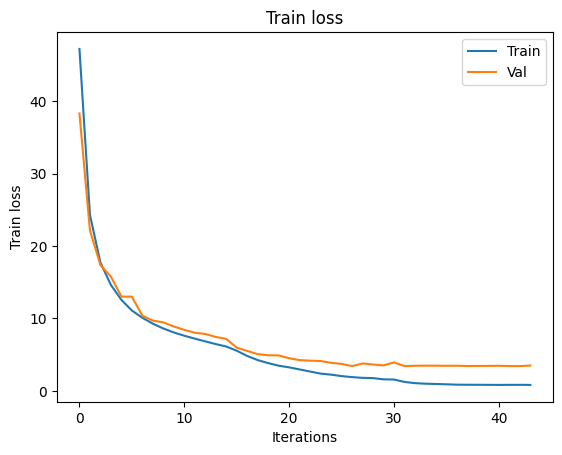

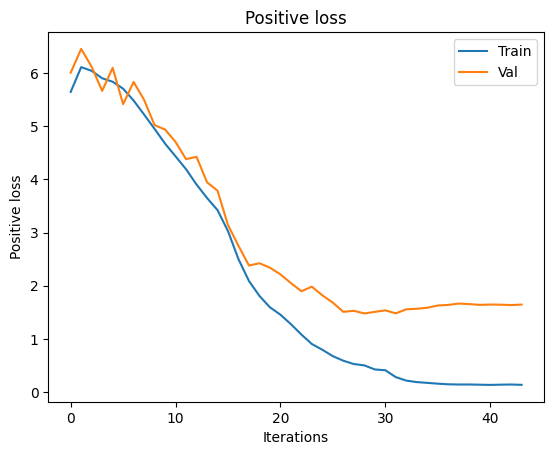

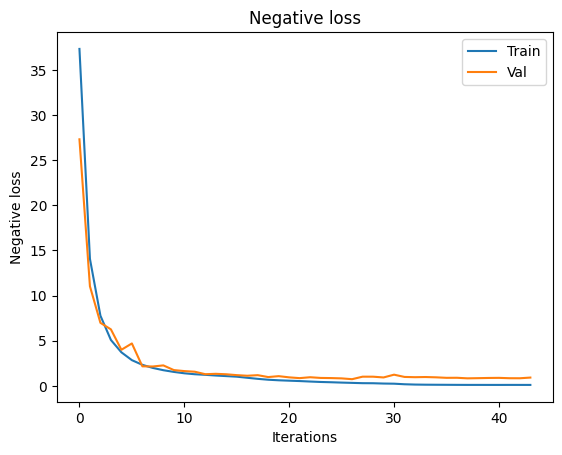

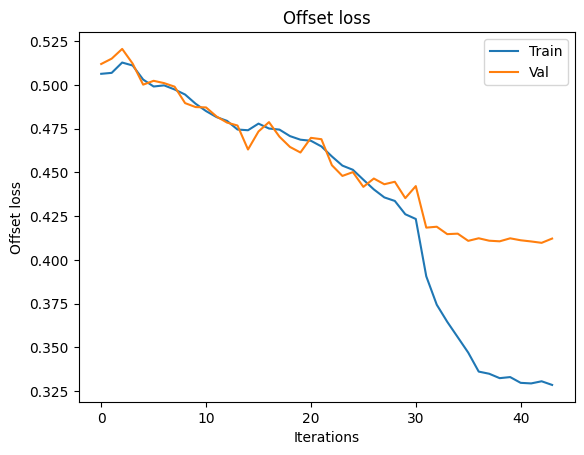

In [37]:
loss_iter = [log["train_loss"] for log in logs]
val_loss_iter = [log["val_loss"] for log in logs]
plt.plot(loss_iter[1:], label="Train")
plt.plot(val_loss_iter[1:], label="Val")
plt.xlabel("Iterations")
plt.ylabel("Train loss")
plt.title("Train loss")
plt.legend()
plt.show()

pos_loss_iter = [log["train_pos_loss"] for log in logs]
val_pos_loss_iter = [log["val_pos_loss"] for log in logs]
plt.plot(pos_loss_iter[1:], label="Train")
plt.plot(val_pos_loss_iter[1:], label="Val")
plt.xlabel("Iterations")
plt.ylabel("Positive loss")
plt.title("Positive loss")
plt.legend()
plt.show()

neg_loss_iter = [log["train_neg_loss"] for log in logs]
val_neg_loss_iter = [log["val_neg_loss"] for log in logs]
plt.plot(neg_loss_iter[1:], label="Train")
plt.plot(val_neg_loss_iter[1:], label="Val")
plt.xlabel("Iterations")
plt.ylabel("Negative loss")
plt.title("Negative loss")
plt.legend()
plt.show()

off_loss_iter = [log["train_off_loss"] for log in logs]
val_off_loss_iter = [log["val_off_loss"] for log in logs]
plt.plot(off_loss_iter[1:], label="Train")
plt.plot(val_off_loss_iter[1:], label="Val")
plt.xlabel("Iterations")
plt.ylabel("Offset loss")
plt.title("Offset loss")
plt.legend()
plt.show()

In [38]:
classes

array(['BINEK', 'KISI', 'PLAKA', 'TAKILDI', 'HORTUM', 'MOTOSIKLET',
       'TICARI', 'NOZZLE', 'TERS', 'BIDON'], dtype=object)

# Show predictions

torch.Size([1, 128, 128])


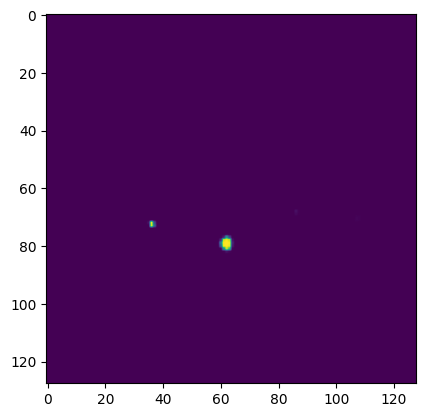

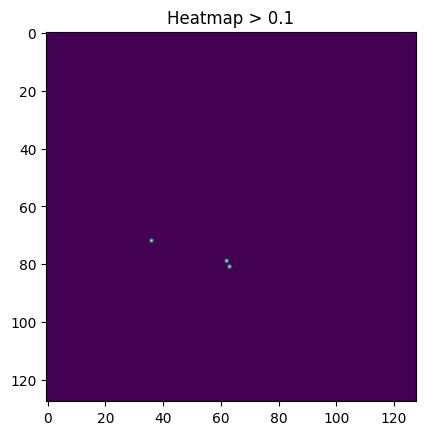

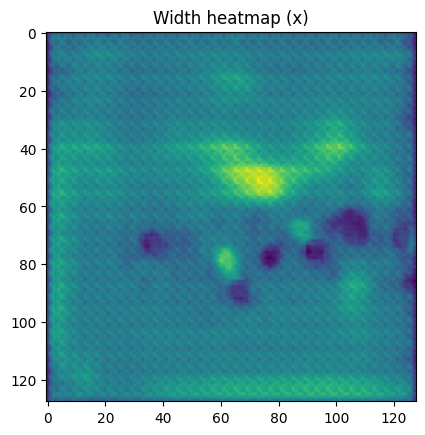

[[ 7.6346083 10.576837 ]
 [27.994272  41.5398   ]
 [29.652973  42.651855 ]]
[[ 7.6346083 27.994272  29.652973 ]
 [10.576837  41.5398    42.651855 ]]
[146, 291]
[249, 318]
[252, 324]


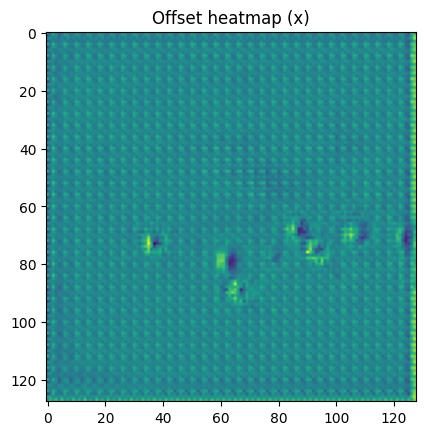

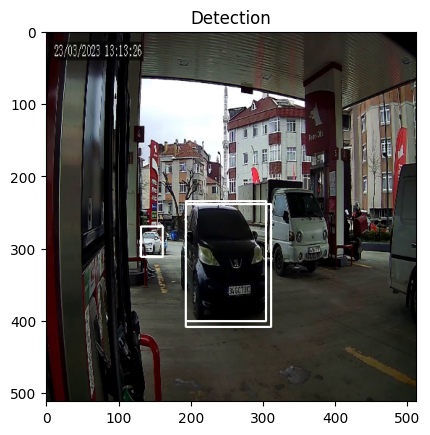

torch.Size([1, 128, 128])


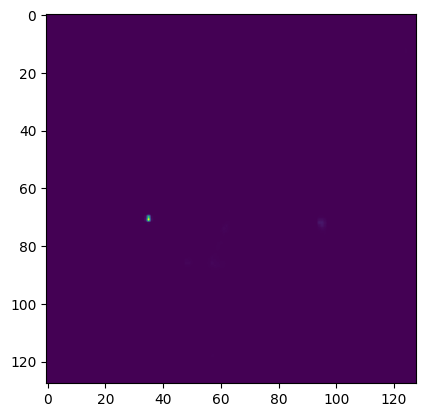

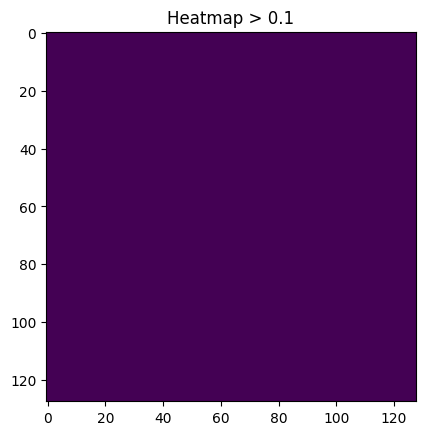

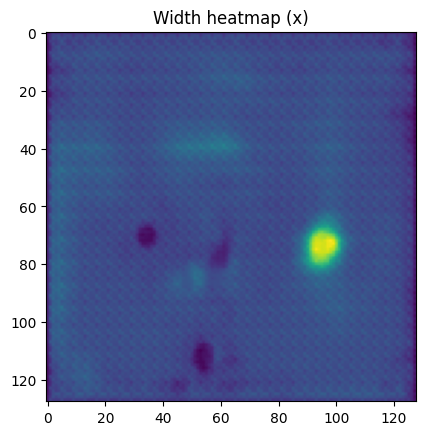

[]
[]


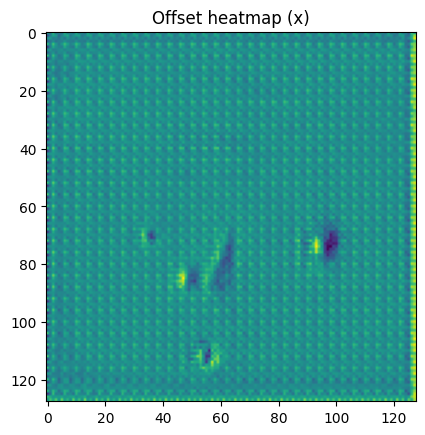

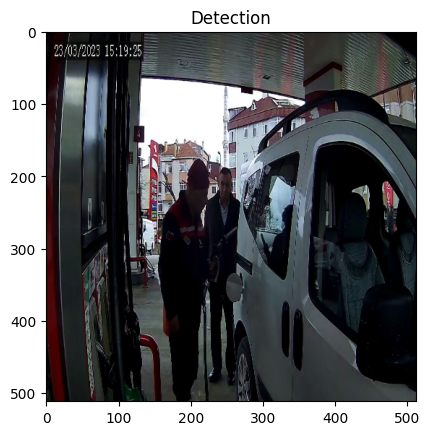

torch.Size([1, 128, 128])


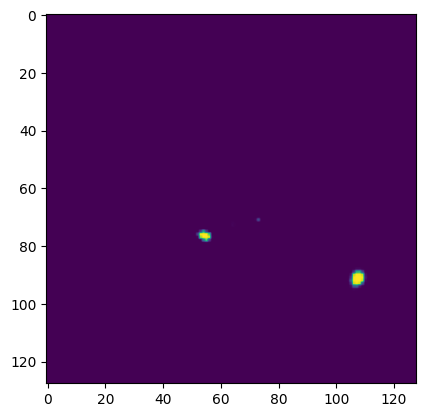

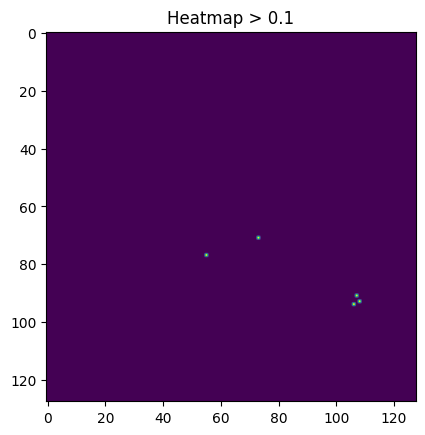

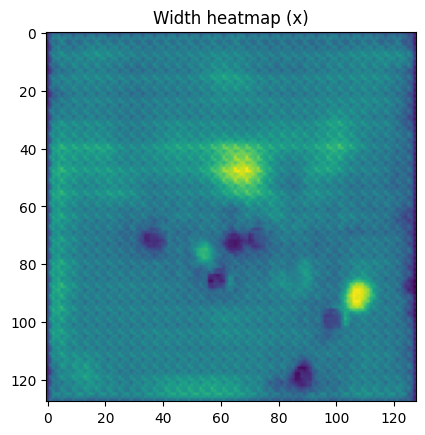

[[10.877965 14.947062]
 [25.294052 33.299534]
 [38.465397 70.58363 ]
 [38.588177 70.092224]
 [37.557796 71.77609 ]]
[[10.877965 25.294052 38.465397 38.588177 37.557796]
 [14.947062 33.299534 70.58363  70.092224 71.77609 ]]
[293, 285]
[220, 308]
[430, 366]
[433, 372]
[426, 376]


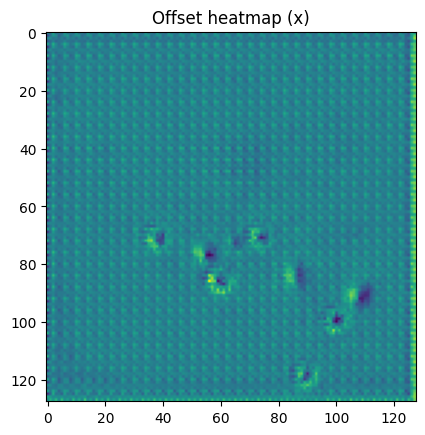

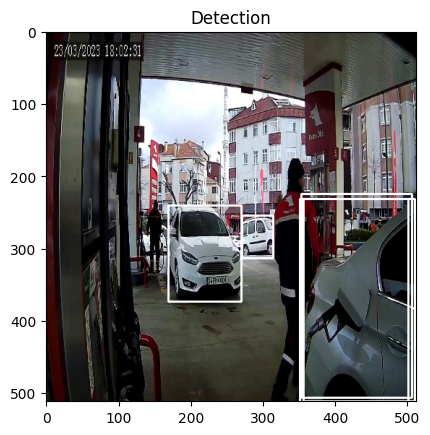

torch.Size([1, 128, 128])


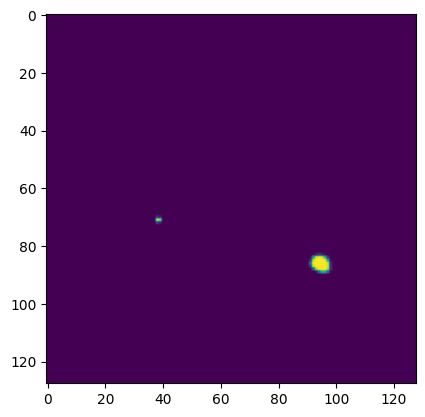

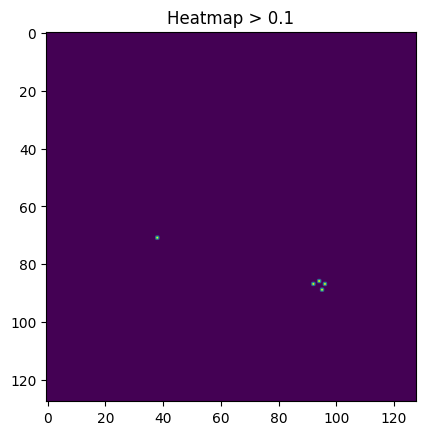

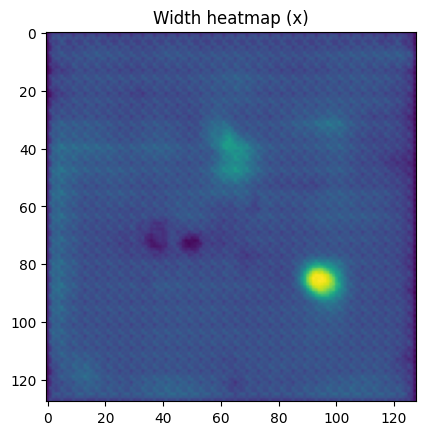

[[10.491751 15.763858]
 [65.585014 84.49205 ]
 [62.91238  85.73135 ]
 [62.27076  82.3284  ]
 [58.334072 82.5588  ]]
[[10.491751 65.585014 62.91238  62.27076  58.334072]
 [15.763858 84.49205  85.73135  82.3284   82.5588  ]]
[155, 286]
[377, 345]
[371, 349]
[385, 349]
[382, 356]


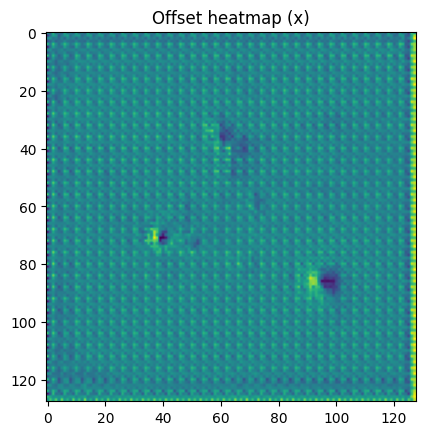

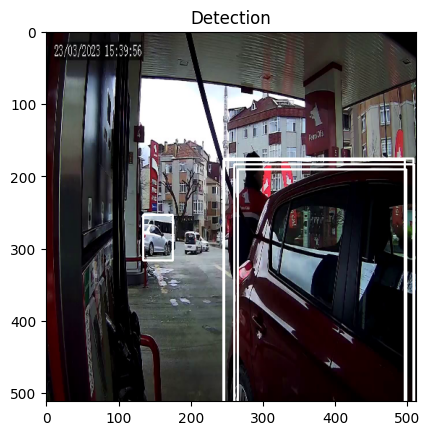

torch.Size([1, 128, 128])


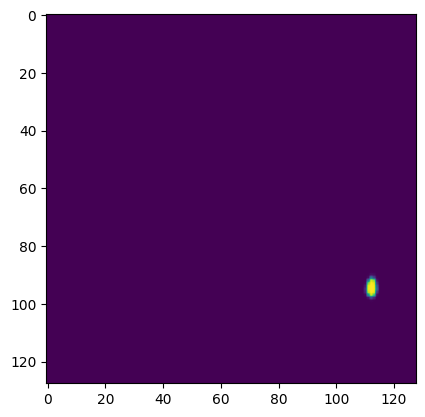

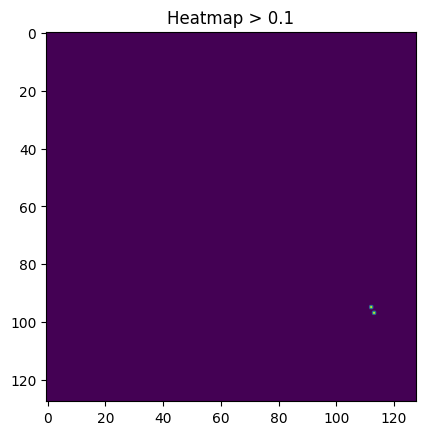

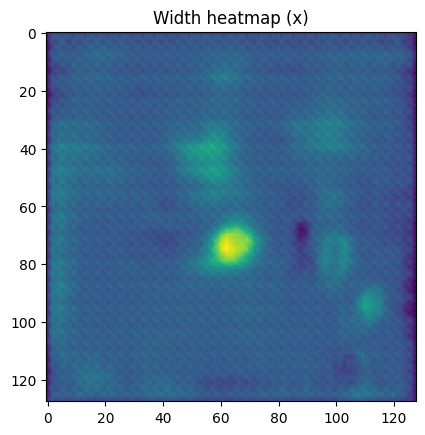

[[30.242641 67.395325]
 [25.53206  65.85554 ]]
[[30.242641 25.53206 ]
 [67.395325 65.85554 ]]
[449, 382]
[453, 389]


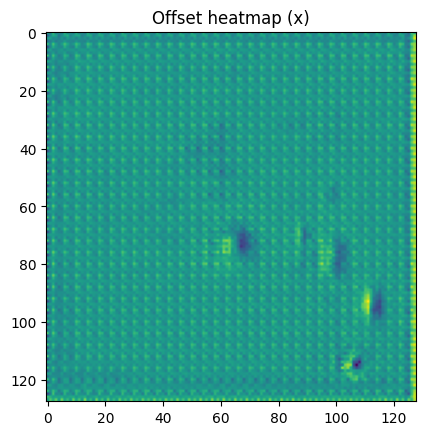

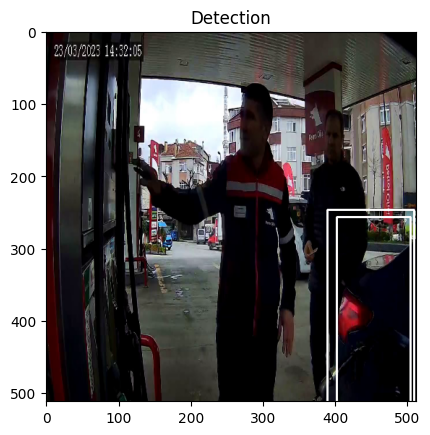

torch.Size([1, 128, 128])


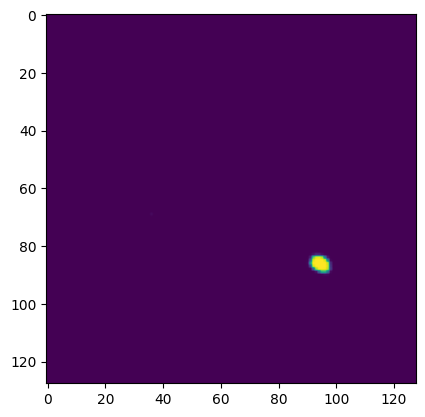

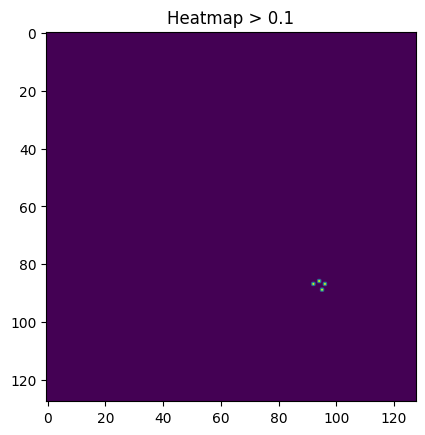

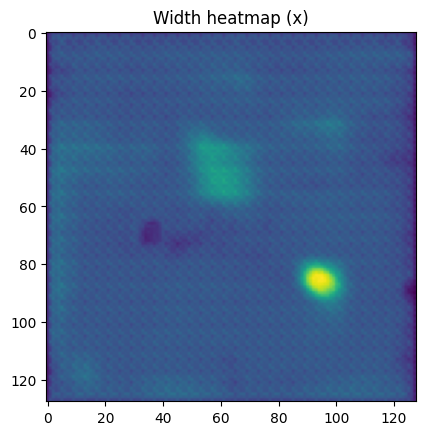

[[65.4625   84.50199 ]
 [62.21908  85.99538 ]
 [62.316643 82.16162 ]
 [58.112713 82.58998 ]]
[[65.4625   62.21908  62.316643 58.112713]
 [84.50199  85.99538  82.16162  82.58998 ]]
[377, 345]
[371, 349]
[385, 349]
[382, 356]


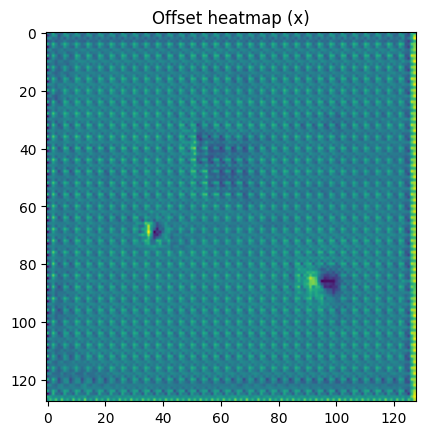

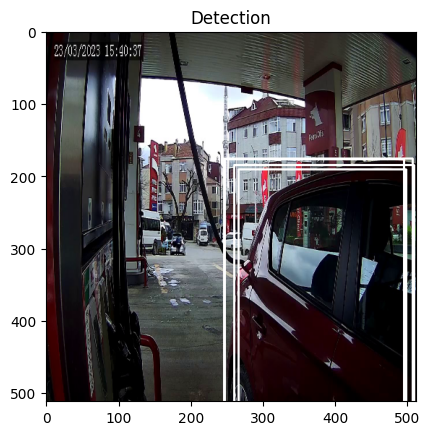

torch.Size([1, 128, 128])


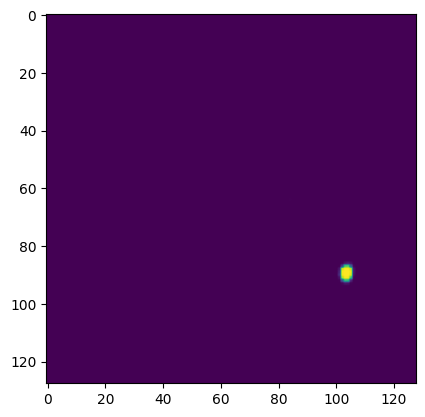

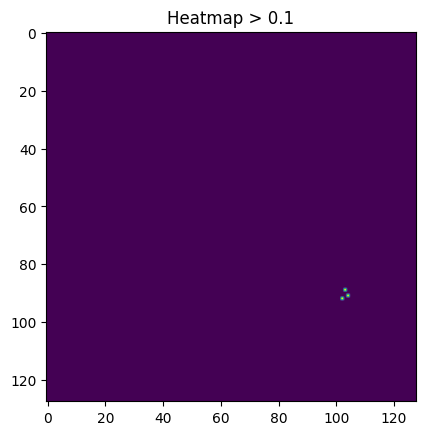

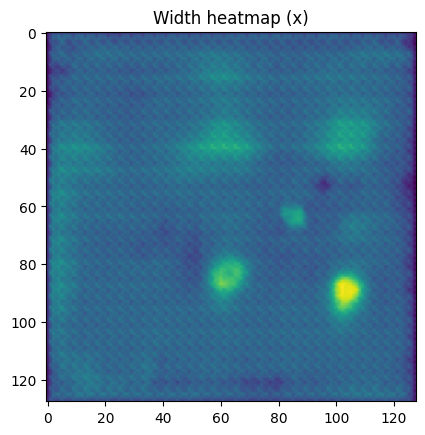

[[47.639454 76.703094]
 [47.374554 76.505356]
 [46.645027 77.054054]]
[[47.639454 47.374554 46.645027]
 [76.703094 76.505356 77.054054]]
[414, 358]
[417, 365]
[410, 368]


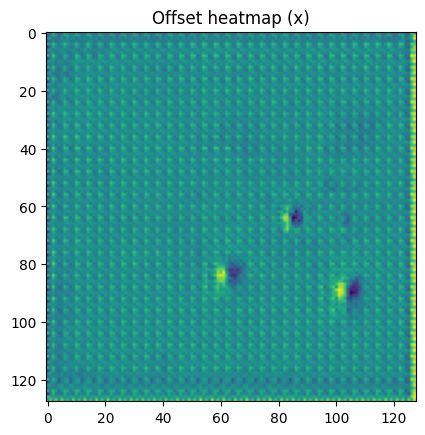

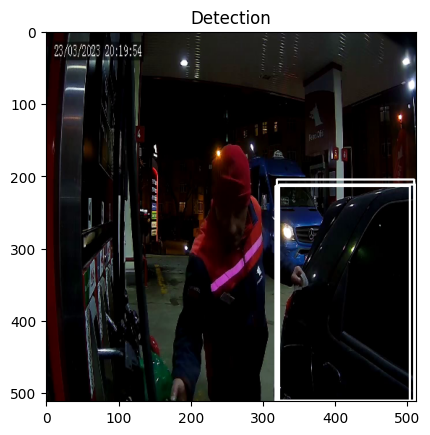

torch.Size([1, 128, 128])


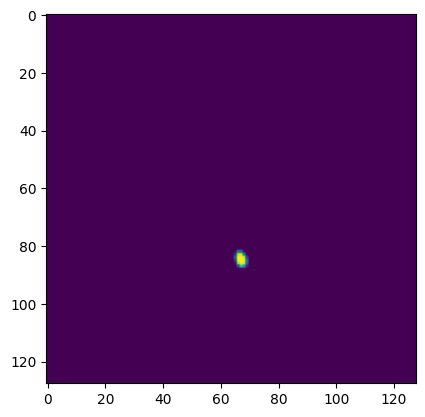

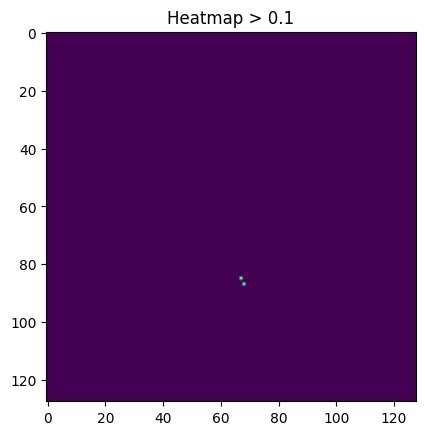

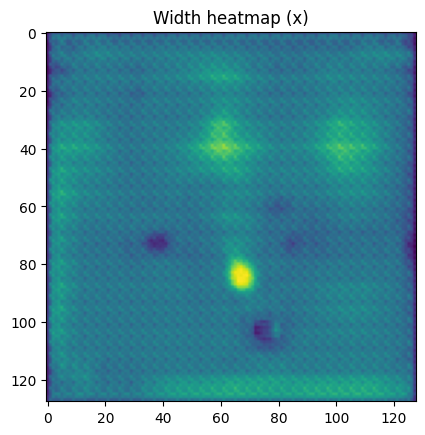

[[41.200718 53.584362]
 [39.493576 55.453087]]
[[41.200718 39.493576]
 [53.584362 55.453087]]
[269, 341]
[273, 349]


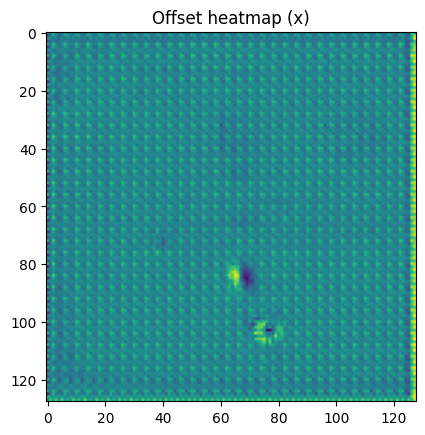

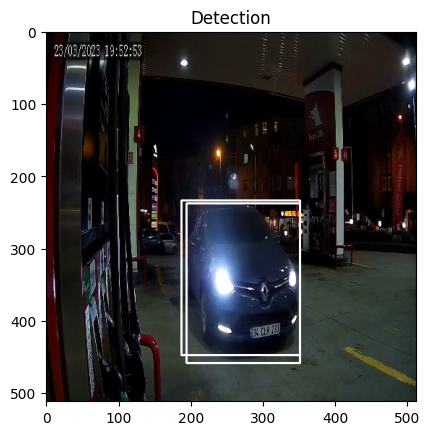

torch.Size([1, 128, 128])


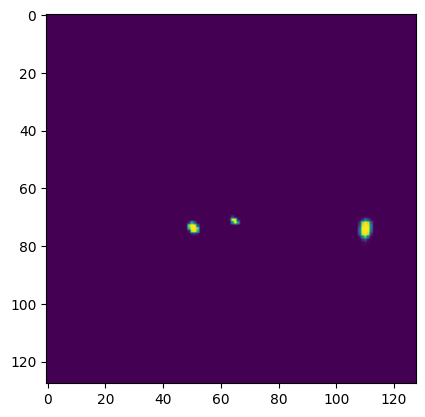

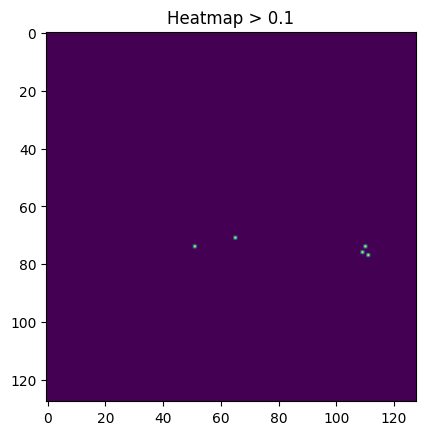

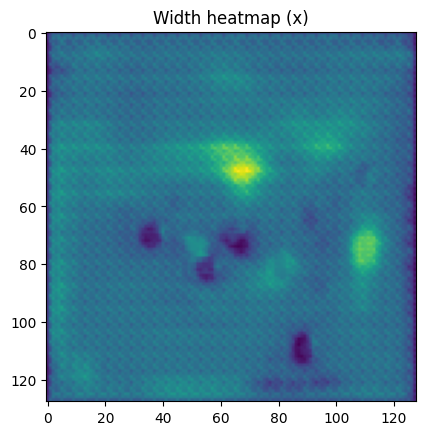

[[  9.029814  13.571653]
 [ 22.692617  31.08503 ]
 [ 33.593777 108.3314  ]
 [ 33.37685  108.520195]
 [ 34.86436  104.81022 ]]
[[  9.029814  22.692617  33.593777  33.37685   34.86436 ]
 [ 13.571653  31.08503  108.3314   108.520195 104.81022 ]]
[261, 287]
[204, 297]
[442, 298]
[439, 304]
[444, 309]


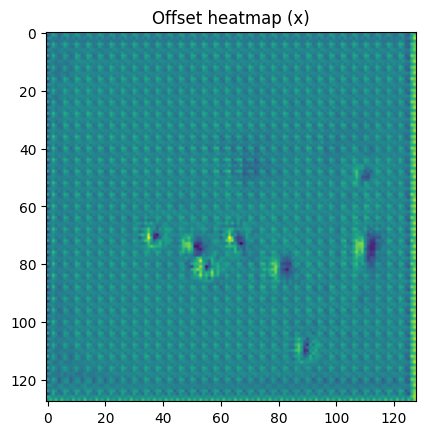

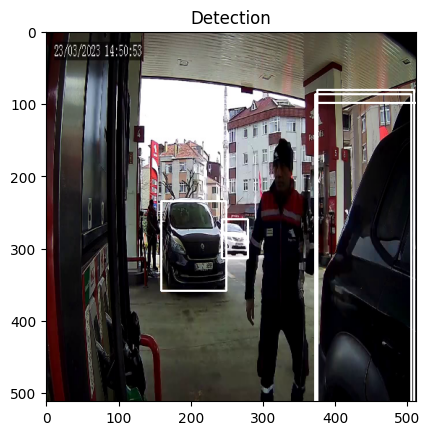

torch.Size([1, 128, 128])


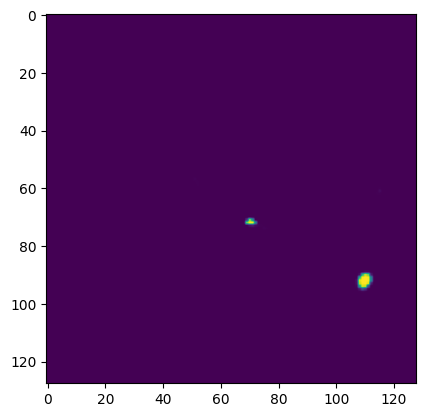

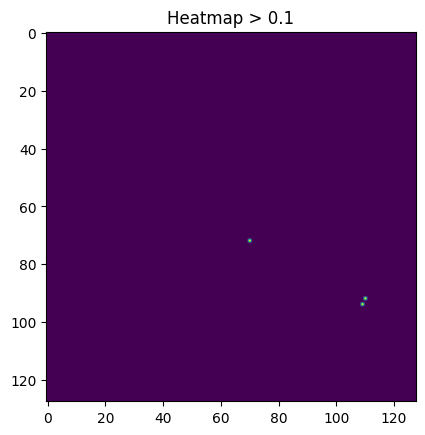

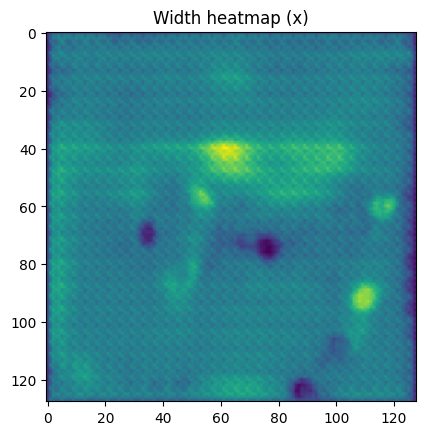

[[13.057541 13.409152]
 [34.63353  69.45612 ]
 [33.48621  68.486084]]
[[13.057541 34.63353  33.48621 ]
 [13.409152 69.45612  68.486084]]
[283, 289]
[441, 369]
[438, 377]


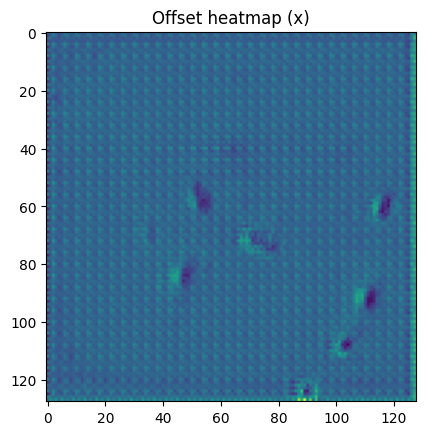

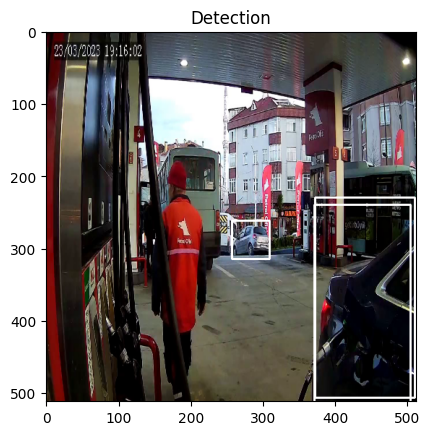

In [39]:
model.load_state_dict(torch.load(f"centernet-fe-{name}.pth"))
model.eval()

threshold = 0.1

for id in range(10):
    img, hm_gt, offset_gt, regr_gt,hm_all = valdataset[id]
    img = torch.from_numpy(img)
    with torch.no_grad():
        hm, offset, wh = model(img.to(device).float().unsqueeze(0))

    #hm = torch.mean(hm,axis=1)
    
    hm = hm[:,0]
    print(hm.shape)
    hm = hm.cpu().numpy().squeeze(0) #.squeeze(0)
    offset = offset.cpu().numpy().squeeze(0)
    wh = wh.cpu().numpy().squeeze(0)
    #angle = angle.cpu().numpy().squeeze(0)
    
    #print(angle.shape)

    # show image
    img_id = val_id[id]
    img = cv2.imread(os.path.join(dataset_folder+"val_images", img_id))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (input_width, input_height))

    # get boxes
    hm = torch.sigmoid(torch.from_numpy(hm)).numpy()
    plt.imshow(hm)
    plt.show()
    hm = select(hm, threshold)
    
    plt.imshow(hm>threshold)
    plt.title(f"Heatmap > {threshold}")
    plt.show()
    
    plt.imshow(wh[0])
    plt.title("Width heatmap (x)")
    plt.show()
    
    sample = showbox(img, hm, offset, wh, threshold)
    plt.imshow(offset[0])
    plt.title("Offset heatmap (x)")
    plt.show()
    
    
    # show gt
    #fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    plt.imshow(sample)
    plt.title("Detection")
    plt.show()